# Module 1: ARMA Processes and Stationarity

For this lab session, we'll be focusing on ARMA($p$, $q$) models and related concepts by discussing several examples and exercises.

First, we import all the necessary Python packages/libraries:

In [2]:
### imports
from __future__ import print_function, division

import pandas as pd
import numpy as np
import scipy.optimize
import scipy.signal
import scipy.stats

import statsmodels.api as sm
from statsmodels import tsa
from datetime import date, datetime, timedelta
import copy

### Check pandas version and import correct web reader
from distutils.version import StrictVersion
if StrictVersion(pd.__version__) >= StrictVersion('0.19'):
    from pandas_datareader import data, wb
else:
    from pandas.io import data, wb

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates
from matplotlib import colors as mcolors

### Plotting and display options
np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

plt.style.use('ggplot')

mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

### figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

### this allows plots to appear directly in the notebook
%matplotlib inline

## Review: ARMA($p$,$q$) models

**Recall:** A stochastic process process $\{x_t\}$ is an ARMA($p$,$q$) process (autoregressive, moving average process of order $p$ and $q$, respectively) if we have

$$
x_t = \mu + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... \phi_p x_{t-p} + \epsilon_{t} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} +  ...  + \theta_q \epsilon_{t-q}
$$

where $\epsilon_{t}$ is white noise, i.e. $E[\epsilon_{t}]=0$ and $Var[\epsilon_{t}]=\sigma^2$, and without loss of generality, we set $\mu$=0.

If the coefficients $\phi_i \equiv 0$, then the ARMA($p$,$q$) process collapses to an MA($q$) process. 

Similarly, if $\theta_i\equiv 0$ then the ARMA($p$,$q$) process collapses to an AR($p$) process.

A slightly more general formulation also used is given by the expression

$$
\sum_{i=0}^{p} \phi_i X_{t-i} = \sum_{i=0}^{q} \theta_i \varepsilon_{t-i}
$$

Note that this formulation introduces $\phi_0,\theta_0$ terms which were implicitly defined to be 1 above. Further, the sign of the AR coefficients is flipped from the first formulation. This is frequently how statistical computing packages treat ARMA($p$,$q$) processes.


Let's simulate some ARMA($p$,$q$) processes. We will later examine both their autocorrelation functions (ACFs) and partial autocorrelation functions (PACFs).


## Example 1: Simulate ARMA($p$,$q$) models

**Problem:** Write a function that simulates an ARMA($p$,$q$) process given parameter inputs. For efficiency purposes, make sure your code is general enough so you can simulate more than one path for an arbitrary sample size $T$.

**Note:** `statsmodels` has a function that generates ARMA($p$,$q$) processes, but for now, write your own function.

The code for simulating an ARMA($p$,$q$) process is found below:

In [2]:
def simulate_arma(ar=[], ma=[], nsample=100, burnin=0, paths=1):
    """Simulate ARMA data
       Assumption: White noise shocks are Gaussian.
    """
    ### numpy arrays are reversed for easier indexing:
    ar, ma = np.array(ar[::-1]), np.array(ma[::-1])
    ### Orders (does not include zero lag)
    p, q = len(ar), len(ma)
    max_order = max(p,q)
    
    ### Total number of sample size
    Nsim = nsample + burnin
    ### "Standard" Guassian shocks: Normal(0,1)
    eps = np.random.randn(paths, Nsim)
    ### Initialize t < 0 with zeros
    eps = np.concatenate((np.zeros((paths, max_order)), eps), axis=1)
    y = np.zeros((paths, Nsim + max_order))
    
    ### Loop to construct the ARMA processes recursively.
    for tt in range(max_order, Nsim + max_order):
        y[:, tt] = np.sum(y[:, tt-p:tt]*ar, axis=1) + np.sum(eps[:,tt-q:tt]*ma, axis=1) + eps[:,tt]
    
    ### Drop initial zeros and burnin and transpose for plotting.
    y = y[:, max_order + burnin:].T
    return y

Equipped with our code, we can now simulate a **Standard Gaussian White Noise** (WN) process and an AR($1$) process with $\phi=0.75$:

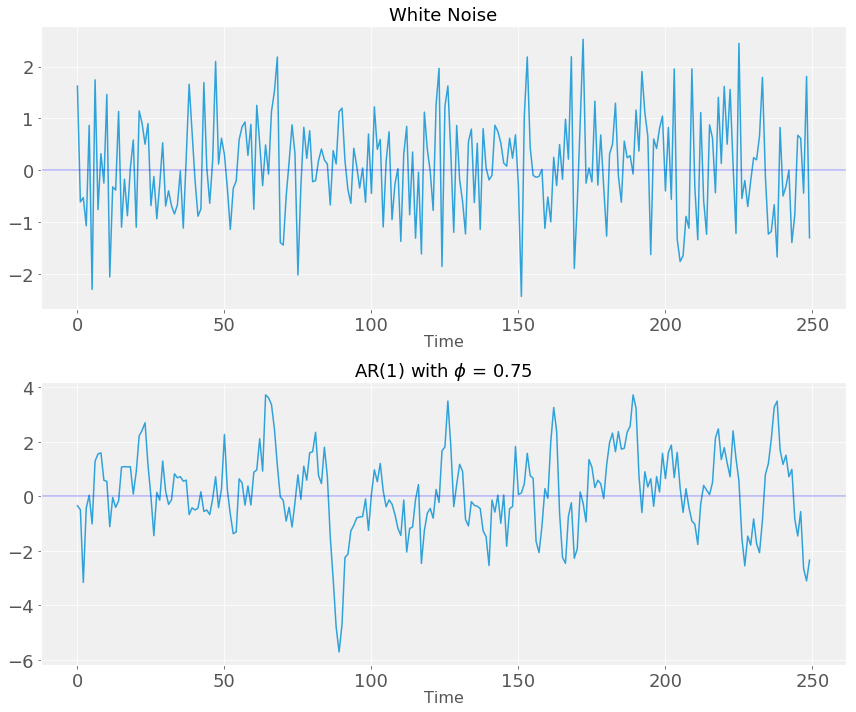

In [3]:
### Seed the random number generator
np.random.seed(1)

### 1. White Noise 
y_wn = simulate_arma(nsample=250)

### 2. AR(1) with persistence = 0.75
phi1_model1 = 0.75
y_ar1_model1 = simulate_arma(ar=[phi1_model1], nsample=250)

fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
axes1[0].plot(y_wn)
axes1[0].set_xlabel('Time', fontsize=16)
axes1[0].set_title('White Noise', fontsize=18)
axes1[0].axhline(y=0, linewidth=0.4)

axes1[1].plot(y_ar1_model1)
axes1[1].set_xlabel('Time', fontsize=16)
axes1[1].set_title('AR($1$)' + ' with $\phi$ = ' + str(phi1_model1) , fontsize=18)
axes1[1].axhline(y=0, linewidth=0.4)

fig1.tight_layout()

### Exercise 1: Simulate ARMA($p$,$q$) models

Now, simulate 5 paths from a few different AR($1$) processes with autoregressive parameters $\phi$ that are a lot more persistent than $\phi=0.75$. 

In addition, let's simulate 5 paths from an MA($1$) process, as well as a non-stationary AR($1$) process with $\phi=1$ 
<br> (**Note:** What type of process is this called?)

For now, set $T=250$ for both processes.

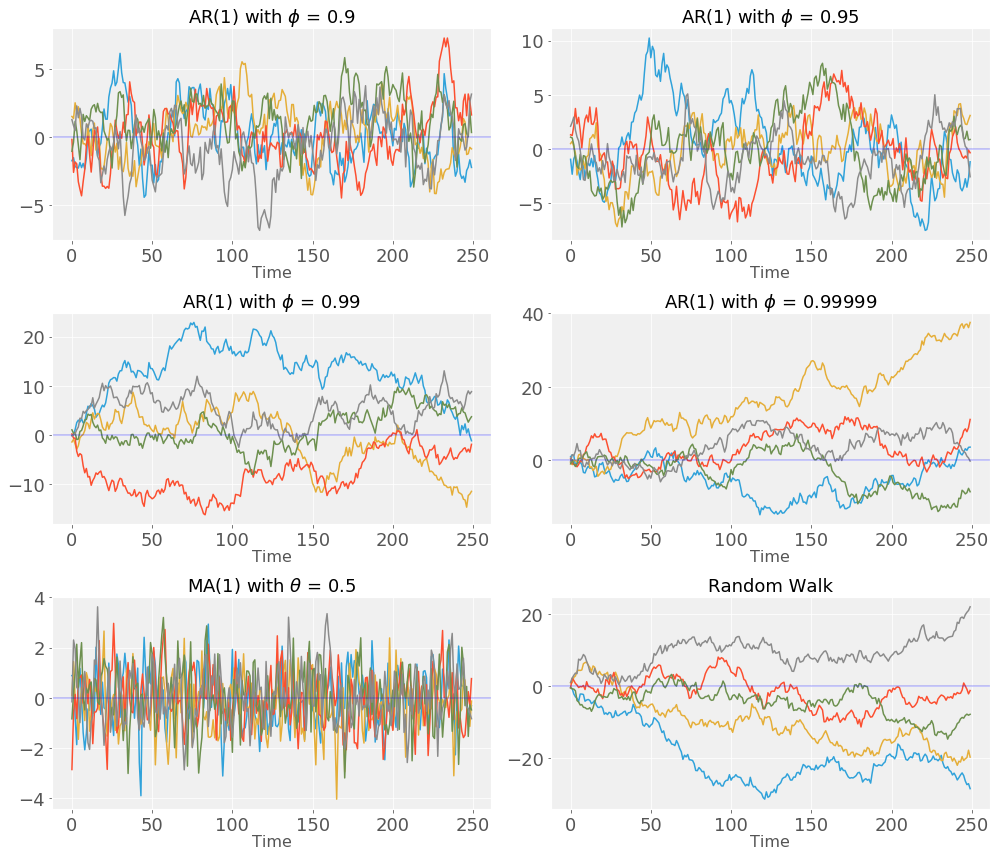

In [4]:
nsampleT = 250

### 1. AR(1) with high persistence = 0.90
phi1_model2 = 0.9
y_ar1_model2 = simulate_arma(ar=[phi1_model2], nsample=nsampleT, paths=5)

### 2. AR(1) with high persistence = 0.95
phi1_model3 = 0.95
y_ar1_model3 = simulate_arma(ar=[phi1_model3], nsample=nsampleT, paths=5)

### 3. AR(1) with high persistence = 0.99
phi1_model4 = 0.99
y_ar1_model4 = simulate_arma(ar=[phi1_model4], nsample=nsampleT, paths=5)

### 4. AR(1) with high persistence = 0.99999
phi1_model5 = 0.99999
y_ar1_model5 = simulate_arma(ar=[phi1_model5], nsample=nsampleT, paths=5)

### 5. MA(1) with theta = 0.5
theta1_model1 = 0.5
y_ma1_model1 = simulate_arma(ma=[theta1_model1], nsample=nsampleT, paths=5)

### 6. Non-stationary AR(1) 
phi1_model6 = 1
y_rw = simulate_arma(ar=[phi1_model6], nsample=nsampleT, paths=5)

### Plot the simulations
fig2, axes2 = plt.subplots(nrows=3, ncols=2, figsize=(14,12))

axes2[0,0].plot(y_ar1_model2)
axes2[0,0].set_xlabel('Time', fontsize=16)
axes2[0,0].set_title('AR($1$)' + ' with $\phi$ = ' + str(phi1_model2), fontsize=18)
axes2[0,0].axhline(y=0, linewidth=0.4)

axes2[0,1].plot(y_ar1_model3)
axes2[0,1].set_xlabel('Time', fontsize=16)
axes2[0,1].set_title('AR($1$)' + ' with $\phi$ = ' + str(phi1_model3), fontsize=18)
axes2[0,1].axhline(y=0, linewidth=0.4)

axes2[1,0].plot(y_ar1_model4)
axes2[1,0].set_xlabel('Time', fontsize=16)
axes2[1,0].set_title('AR($1$)' + ' with $\phi$ = ' + str(phi1_model4), fontsize=18)
axes2[1,0].axhline(y=0, linewidth=0.4)

axes2[1,1].plot(y_ar1_model5)
axes2[1,1].set_xlabel('Time', fontsize=16)
axes2[1,1].set_title('AR($1$)' + ' with $\phi$ = ' + str(phi1_model5), fontsize=18)
axes2[1,1].axhline(y=0, linewidth=0.4)

axes2[2,0].plot(y_ma1_model1)
axes2[2,0].set_xlabel('Time', fontsize=16)
axes2[2,0].set_title('MA($1$)' + ' with $\\theta$ = ' + str(theta1_model1), fontsize=18)
axes2[2,0].axhline(y=0, linewidth=0.4)

axes2[2,1].plot(y_rw)
axes2[2,1].set_xlabel('Time', fontsize=16)
axes2[2,1].set_title('Random Walk', fontsize=18)
axes2[2,1].axhline(y=0, linewidth=0.4)

fig2.tight_layout()

### Exercise 2: Guess the ARMA($p$,$q$) processes!

By looking at the 5 following paths, can you guess the 5 respective ARMA($p$,$q$) processes that generate the paths?

Let's load in the .csv files `'Exercise2_smallT_arma_sims.csv` and `'Exercise2_largeT_arma_sims.csv`. 
The first file contains simulated processes with <u>small</u> $T$ sample size, while the second file contains simulated processes with <u>large</u> $T$ sample size.

In [5]:
### Read in simulated processes
df_Exercise2_smallT = pd.read_csv('Exercise2_smallT_arma_sims.csv', header=0)
df_Exercise2_largeT = pd.read_csv('Exercise2_largeT_arma_sims.csv', header=0)
print(df_Exercise2_smallT.head(), '\n')
print(df_Exercise2_largeT.head(), '\n')

### Get info about the 2 'DataFrames'
print(df_Exercise2_smallT.info(), '\n')
print(df_Exercise2_largeT.info())

   y_process1_smallT  y_process2_smallT  y_process3_smallT  y_process4_smallT
0             -2.219             -0.016              0.911              0.142
1             -2.898             -0.728              1.660              0.022
2              0.903             -1.111              0.940             -0.010
3              0.037             -0.605              2.864              1.808
4             -0.393              0.360              1.962              1.295 

   y_process1_largeT  y_process2_largeT  y_process3_largeT  y_process4_largeT
0             -1.869              0.733              1.351             -1.129
1              0.641             -1.087              1.138             -0.446
2              2.663              1.023              0.892             -0.325
3              1.719              0.826              0.976             -0.138
4              1.542             -0.937              0.529              0.558 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entrie

#### Exercise 2.1: Guess this process

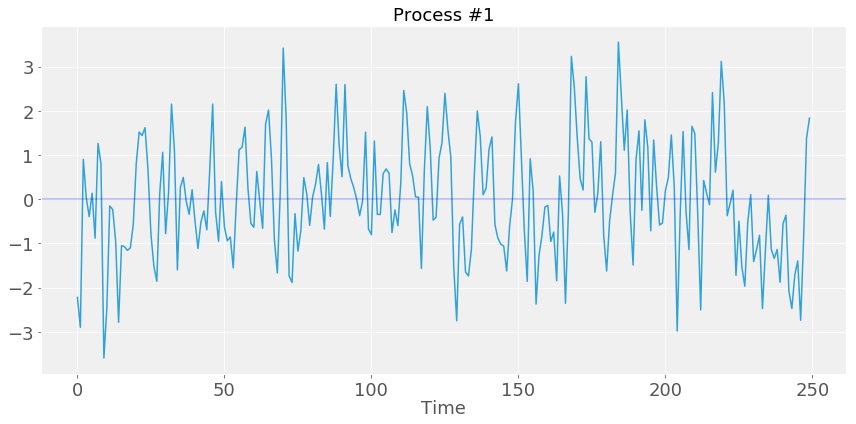

In [6]:
fig3, axes3 = plt.subplots(figsize=(12,6))
axes3.plot(df_Exercise2_smallT.y_process1_smallT)
axes3.set_xlabel('Time', fontsize=18)
axes3.set_title('Process #1', fontsize=18)
axes3.axhline(y=0, linewidth=0.4)
fig3.tight_layout()

#### Solution to Exercise 2.1:
This is an MA($1$) process with $\theta=0.75$

#### Exercise 2.2: Guess this process

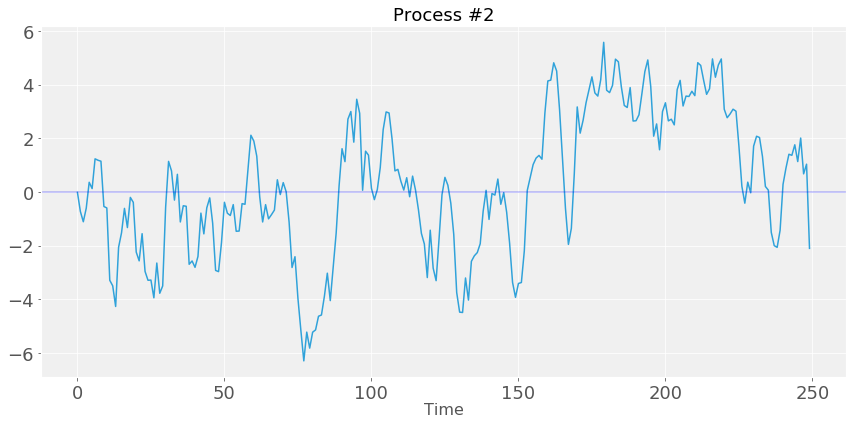

In [7]:
fig4, axes4 = plt.subplots(figsize=(12,6))
axes4.plot(df_Exercise2_smallT.y_process2_smallT)
axes4.set_xlabel('Time', fontsize=16)
axes4.set_title('Process #2', fontsize=18)
axes4.axhline(y=0, linewidth=0.4)
fig4.tight_layout()

#### Solution to Exercise 2.2:
This is an ARMA($1$,$1$) process with $\phi=0.9$ and $\theta=0.2$

#### Exercise 2.3:  Guess this process

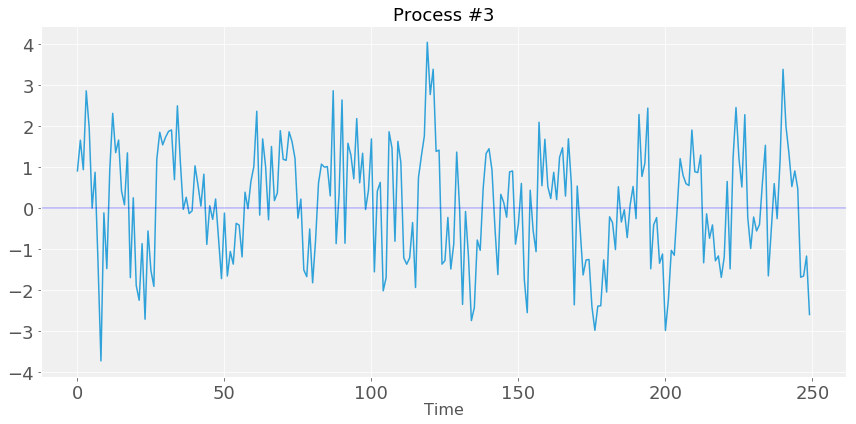

In [8]:
fig5a, axes5a = plt.subplots(figsize=(12,6))
axes5a.plot(df_Exercise2_smallT.y_process3_smallT)
axes5a.set_xlabel('Time', fontsize=16)
axes5a.set_title('Process #3', fontsize=18)
axes5a.axhline(y=0, linewidth=0.4)
fig5a.tight_layout()

#### Solution to Exercise 2.3:
This is an MA($3$) process with $\theta_1=0.25$, $\theta_2=0.5$, and $\theta_3=0.75$.

#### Exercise 2.4:  Guess this process

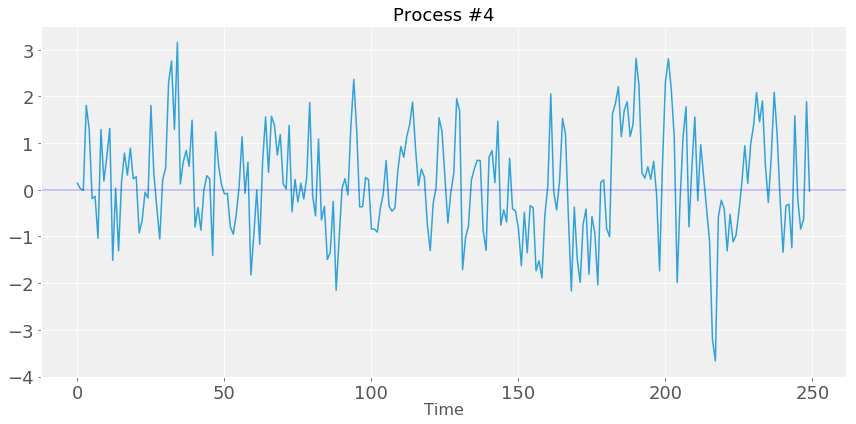

In [9]:
fig5b, axes5b = plt.subplots(figsize=(12,6))
axes5b.plot(df_Exercise2_smallT.y_process4_smallT)
axes5b.set_xlabel('Time', fontsize=16)
axes5b.set_title('Process #4', fontsize=18)
axes5b.axhline(y=0, linewidth=0.4)
fig5b.tight_layout()

#### Solution to Exercise 2.4:
This is an ARMA($2$, $1$) process with $\phi_1=0.833$, $\phi_2=-0.167$, and $\theta_1=-0.339$.

#### Exercise 2.5:  Guess this process

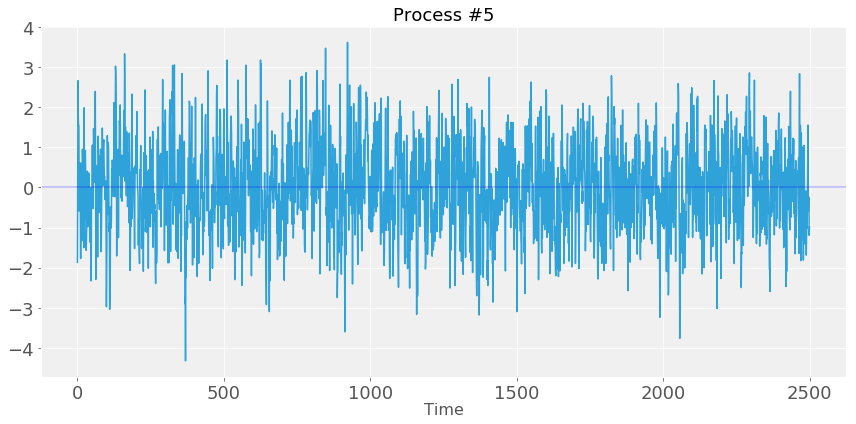

In [10]:
fig5c, axes5c = plt.subplots(figsize=(12,6))
axes5c.plot(df_Exercise2_largeT.y_process1_largeT)
axes5c.set_xlabel('Time', fontsize=16)
axes5c.set_title('Process #5', fontsize=18)
axes5c.axhline(y=0, linewidth=0.4)
fig5c.tight_layout()

#### Solution to Exercise 2.5:
This is also an ARMA($2$, $1$) process with $\phi_1=0.833$, $\phi_2=-0.167$, and $\theta_1=-0.339$.

### Discussion of Exercises 2.4 and 2.5:

What is particularly interesting about the ARMA($2$,$1$) process shown in the last two exercises? Let's  write down the process using factored lag polynomials for both its AR and MA components:

$$
x_t = 0.833 x_{t-1} - 0.167 x_{t-2} + \epsilon_{t} - 0.339 \epsilon_{t-1}
$$
$$
\implies (1 - 0.833 L + 0.167 L^2)x_{t} = (1 -  0.339 L)\epsilon_{t}
$$

Factoring the AR(2) lag polynomial $\Phi(L)$ yields approximately: 

$$
\implies (1 - 0.833 L + 0.167 L^2) \approx (1 - 0.5 L)(1 - 0.333 L)
$$

which gives us the (approximate) AR roots $\frac{1}{\lambda_1}\approx2$ and $\frac{1}{\lambda_2}\approx3$. The (factored) MA lag polynomial $\Theta(L)$ has the single root $\frac{1}{\zeta_1}\approx 2.949$

Thus the ARMA($2$,$1$) almost exhibits what we call a "common factor". That is,  $\Phi(L)$ and $\Theta(L)$ almost have a **common zero**: 

<tab>The AR factor $(1 - 0.333 L)$ is almost identical to the MA factor $(1 -  0.339 L)$ i.e. they "almost" cancel each other out. 

**Questions:** What does this mean for the ARMA($2$,$1$) process? Specifically, what happens if the MA factor was exactly $(1 -  0.333 L)$?  

**Note:** In practice, for small $T$, it may be difficult to "identify" the data generating process (think about **Exercises 2.4** and **2.5** in this notebook)

### Exercise 3: OLS Regression Estimation from "scratch"

**Problem:** Write a function that returns the parameter estimates and residuals from a *simple OLS regression estimation*.

**Note:** It's helpful to include an option that allows you to <u>add a constant</u> within the function, although this is up to you. If you do add a constant within your function, it can be useful to return the new matrix as well. 

Once again, `statsmodels` and other Python libraries have functions for running linear regressions. For now, write your own function.

In [11]:
def calc_ols(y, x, addcon=True):
    """Calculate OLS coefficients from scratch"""
    Nobs = y.shape[0]
    if addcon:
        X = np.c_[np.ones((Nobs,1)), x] # append the [Nobs x 1] columns of ones.
    else:
        X = x
    XX = np.dot(X.T, X) # Construct sample average of E[X'X]
    Xy = np.dot(X.T, y) # Construct sample average of E[X'Y]
    beta_hat = np.linalg.solve(XX, Xy) # algebraic solution for OLS. beta_hat = (E[X'X]^-1)*(E[X'Y])
    resids = y - np.dot(X, beta_hat) # residual eps_hat = y - beta_hat*X 
    return beta_hat, resids, X

Below, I present a "wrapper" for the `statsmodels` OLS regression estimation routine so it returns the parameter estimates and residuals in one function.

In [12]:
### See: https://stackoverflow.com/questions/20701484/why-do-i-get-only-one-parameter-from-a-statsmodels-ols-fit
def _sm_calc_ols(y, x, addcon=True):
    """Wrapper for statsmodels OLS regression"""
    X = sm.add_constant(x) if addcon else x # add a constant if addcon==True=1
    ols_results = sm.OLS(y,X).fit()
    beta_hat = ols_results.params # beta_hat
    resids = ols_results.resid  # resids
    return beta_hat, resids, X

We can now compare our "brute force" OLS regression estimation function with that of `statsmodels`:

In [13]:
### PART 1: Test the function on simulated data
nsample_T = 1000

np.random.seed(1)
x1 = np.random.normal(size=nsample_T )
x2 = np.random.normal(size=nsample_T )
eps = np.random.normal(size=nsample_T )

# Simple simulation of an AR(2)
y = 2 + -3*x1 + .1*x2 + eps 

x = np.c_[x1, x2] # https://docs.scipy.org/doc/numpy/reference/generated/numpy.c_.html

### NOTE: calc_ols(y,x) returns "beta_hat, resids, X"
###       If we only want beta_hat, then we use "_,_" so we don't return the other 3 objects.
beta_hat, _,_ = calc_ols(y,x) 
print('Estimates (using our "brute force" function): ', beta_hat, '\n')

beta_hat, _,_ = _sm_calc_ols(y,x, addcon=True)
print('Estimates (using statsmodels): ', beta_hat, '\n')

### PART 2: Estimate an AR(1) with theta = 0.75 using OLS estimation:
y_ar1 = simulate_arma(ar=[.75], nsample=nsample_T )
beta_hat_ar1, _,_ = calc_ols(y_ar1[1:], y_ar1[:-1])
print('Estimates of an AR(1) process with' + ' phi=0.75 using OLS estimation:', 
      '\n\tintercept (mu):', round(beta_hat_ar1[0].item(), 3), '\n\tphi:', round(beta_hat_ar1[1].item(), 3))

Estimates (using our "brute force" function):  [ 1.981 -3.05   0.071] 

Estimates (using statsmodels):  [ 1.981 -3.05   0.071] 

Estimates of an AR(1) process with phi=0.75 using OLS estimation: 
	intercept (mu): 0.004 
	phi: 0.758


## Example 2: Estimate the  *ACF* and *PACF* of processes from Example 1 by OLS regression

Using your "brute force" OLS function, write additional functions that both estimate and plot the *ACF* and *PACF* via OLS.

**Note:** compare with the `statsmodels` methods:
* `sm.tsa.stattools.acf`, `sm.graphics.tsa.plot_acf`
* `sm.tsa.stattools.pacf`, `sm.graphics.tsa.plot_pacf`

Both of these functions have multiple methods for estimation; we'll stick with OLS.

In [94]:
def lag_mat(y,nlags, fill_vals=np.nan):
    """Create a matrix of lags of a given vector"""
    ### Source: https://docs.scipy.org/doc/numpy/reference/generated/numpy.empty.html
    y_lags = np.empty((y.shape[0], nlags+1)) 
    y_lags.fill(fill_vals)
    
    ### Include 0 lag
    for lag in range(nlags + 1):
        ### Source: https://docs.scipy.org/doc/numpy/reference/generated/numpy.roll.html
        ### np.roll --> Elements that roll beyond the last position are re-introduced at the first.
        y_lags[lag:, lag] = np.roll(y, shift=lag)[lag:] 
    return y_lags

### ACF and PACF for a given lag
def calc_acf_lag_ols(y_lags, lag):
    """ACF for a given lag (OLS)"""
    if lag==0: 
        return 1.
    lhs = y_lags[lag:, 0]
    rhs = y_lags[lag:, lag:lag+1]
    beta_hat, _,_ = calc_ols(y=lhs, x=rhs, addcon=True)
    return beta_hat[-1]

def calc_pacf_lag_ols(y_lags, lag):
    """PACF for a given lag (OLS)"""
    if lag==0: 
        return 1.
    lhs = y_lags[lag:, 0]
    ### need y_lags[lag:, 1:lag+1] instead of y_lags[lag:,lag:lag+1] (unlike "calc_acf_lag_ols")
    rhs = y_lags[lag:, 1:lag+1] 
    beta_hat, _,_ = calc_ols(y=lhs, x=rhs, addcon=True)
    return beta_hat[-1]

### ACF and PACF for all lags
def calc_acf_ols(y, nlags):
    """ACF for multiple lags"""
    y_lags = lag_mat(y,nlags)
    acf_list = [calc_acf_lag_ols(y_lags,lag) for lag in range(nlags + 1)]
    return np.array(acf_list)

def calc_pacf_ols(y, nlags):
    """PACF for multiple lags"""
    y_lags = lag_mat(y,nlags)
    pacf_list = [calc_pacf_lag_ols(y_lags,lag) for lag in range(nlags + 1)]
    return np.array(pacf_list)

### Plotting functions
def my_plot_acf(y, nlags=10, ax=None, title_string='', 
                title_fontsize=None, xlabel_string='Time'):
    """Plotting ACF with approx SEs."""
    T = y.shape[0] 
    ### approx SEs: scaling used in aysmptotic
    se_approx = 1/np.sqrt(T)
    ### set up figure
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    ### ACF
    ax.plot(calc_acf_ols(y, nlags), c='xkcd:true blue', 
            marker='o', markerfacecolor='xkcd:azure')
    ax.fill_between(x=range(0,nlags+1), y1=-1.96*se_approx, y2=1.96*se_approx, facecolor='blue', alpha=0.1)
    ax.set_xlabel(xlabel_string)
    if title_fontsize!=None:
        ax.set_title('${\it ACF}$: ' + title_string, fontsize=title_fontsize)
    else:
        ax.set_title('${\it ACF}$: ' + title_string)
    
def my_plot_pacf(y, nlags=10, ax=None, title_string='', 
                 title_fontsize=None, xlabel_string='Time'):
    """Plotting PACF with approx SEs."""
    T = y.shape[0]
    # approx SEs: scaling used in aysmptotic
    se_approx = 1/np.sqrt(T)
    # set up figure
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    # PACF
    ax.plot(calc_pacf_ols(y, nlags), c='xkcd:true blue', 
            marker='o', markerfacecolor='xkcd:azure')
    ax.fill_between(x=range(0,nlags+1), y1=-1.96*se_approx, y2=1.96*se_approx, facecolor='blue', alpha=0.1)
    ax.set_xlabel(xlabel_string)
    if title_fontsize!=None:
        ax.set_title('${\it PACF}$: ' + title_string, fontsize=title_fontsize)
    else:
        ax.set_title('${\it PACF}$: ' + title_string)
    

Let's plot the *ACF* and *PACF* for our **Standard Gaussian White Noise** (WN) process and an AR($1$) process with $\phi=0.75$:

In [15]:
###
### NOTE: only simulate "one" path! (can use np..squeeze() to collapse to remove single-dimensional entries)
###

### 1. White Noise 
y_wn = simulate_arma(nsample=100).squeeze() 

### 2. AR(1) with persistence = 0.75
phi1_model1 = 0.75
y_ar1_model1 = simulate_arma(ar=[phi1_model1], nsample=100).squeeze() 

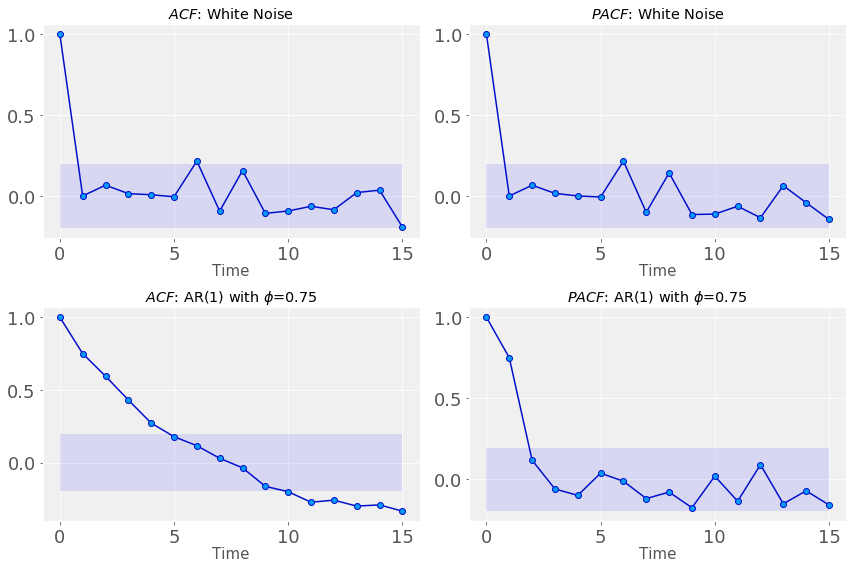

In [23]:
### ACF/PACF plots
nlags = 15
fig6, axes6 = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

my_plot_acf(y_wn, nlags , ax=axes6[0,0], title_string="White Noise")
my_plot_pacf(y_wn, nlags , ax=axes6[0,1], title_string="White Noise")

my_plot_acf(y_ar1_model1, nlags, ax=axes6[1,0], title_string="AR(1) with $\\phi$=" + str(phi1_model1))
my_plot_pacf(y_ar1_model1, nlags , ax=axes6[1,1], title_string="AR(1) with $\\phi$=" + str(phi1_model1))

fig6.tight_layout()

Let's compare our "brute force" results from above to those we would get if we used `statsmodels`:

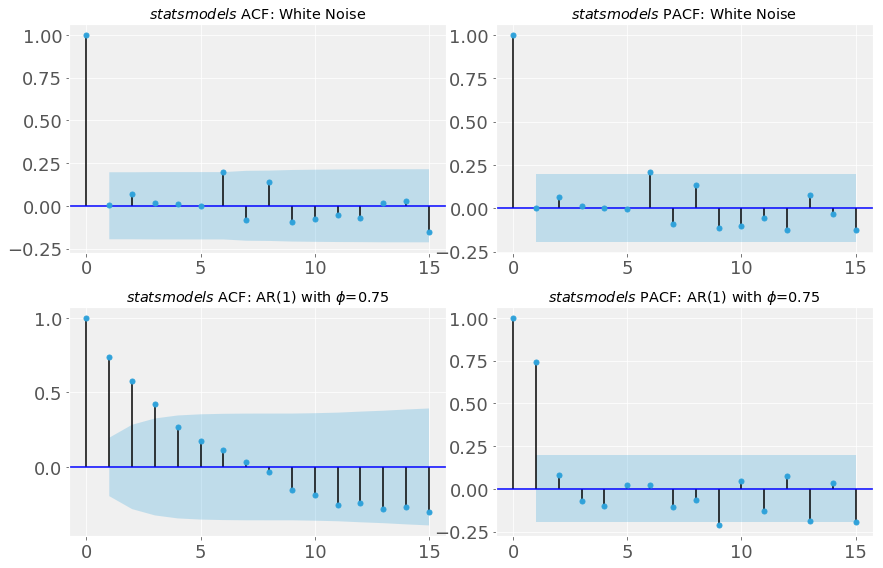

In [24]:
### import 'statsmodels' routines for  ACF/PACF plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
nlags = 15

fig7, axes7 = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

plot_acf(y_wn, ax=axes7[0,0], lags=nlags, 
         title="${\it statsmodels}$ ACF: White Noise")
plot_pacf(y_wn, ax=axes7[0,1], lags=nlags, 
          title="${\it statsmodels}$ PACF: White Noise")

plot_acf(y_ar1_model1, ax=axes7[1,0], lags=nlags, 
         title="${\it statsmodels}$ ACF: AR(1) with $\\phi$=" + str(phi1_model1))
plot_pacf(y_ar1_model1, ax=axes7[1,1], lags=nlags, 
          title="${\it statsmodels}$ PACF: AR(1) with $\\phi$=" + str(phi1_model1))

fig7.tight_layout()

Our *ACF* and *PACF* plots are visually nicer! :)

### Exercise 4: Estimate the  *ACF* and *PACF* of the processes from Exercise 2 by OLS regression

Now, estimate the *ACF* and *PACF* for the same processes from **Exercise 2**. Only simulate once!

Recall the processes we simulated:

1. AR($1$) with $\phi=0.9$
2. AR($1$) with $\phi=0.95$
3. AR($1$) with $\phi=0.99$
4. AR($1$) with $\phi=0.99999$
5. MA($1$) with $\theta=0.5$
6. Random Walk 

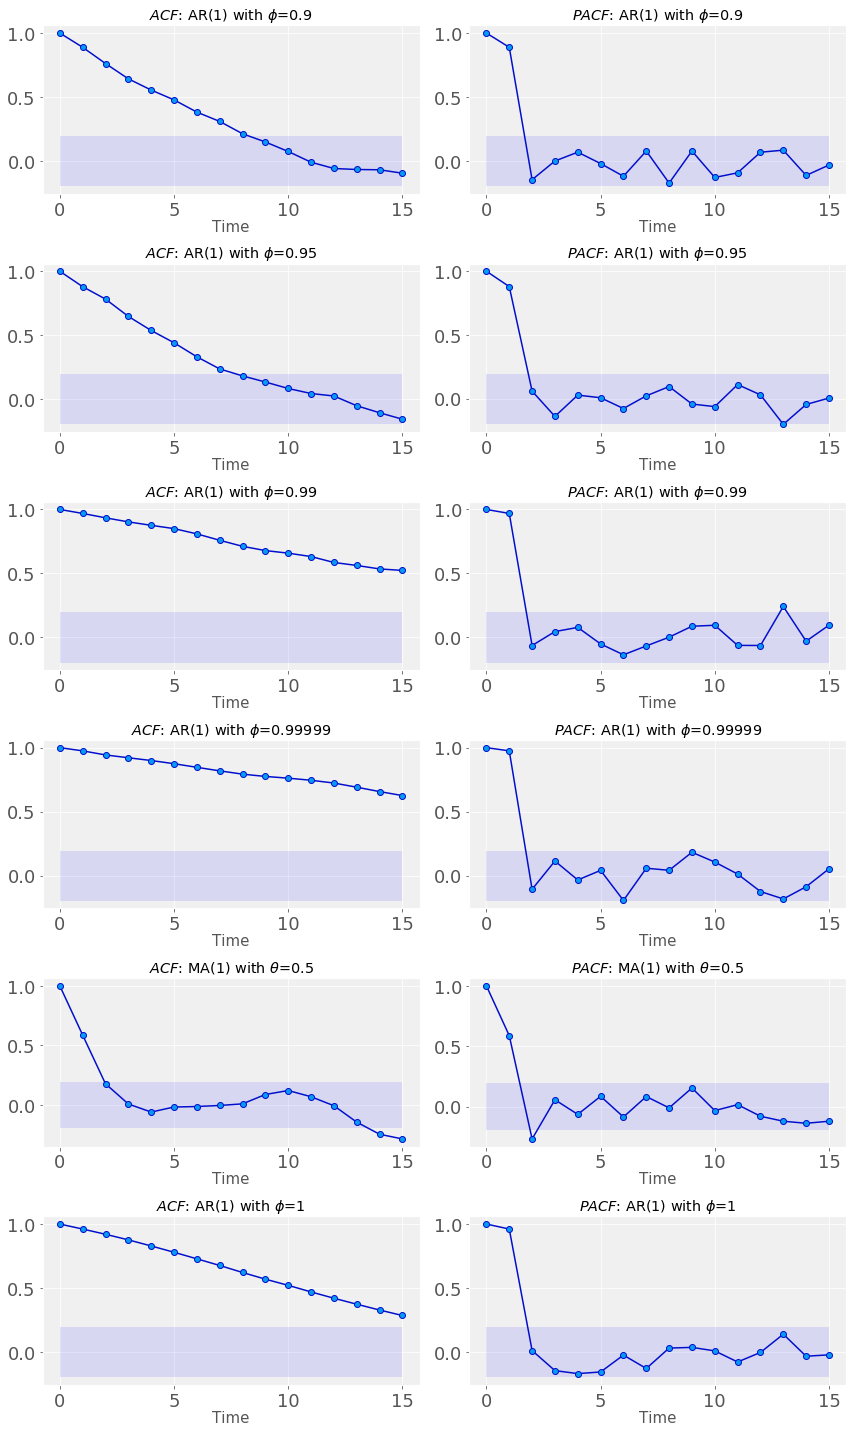

In [25]:
nsample_T = 100

### 1. AR(1) with high persistence = 0.90
phi1_model2 = 0.9
y_ar1_model2 = simulate_arma(ar=[phi1_model2], nsample=nsample_T).squeeze()

### 2. AR(1) with high persistence = 0.95
phi1_model3 = 0.95
y_ar1_model3 = simulate_arma(ar=[phi1_model3], nsample=nsample_T).squeeze()

### 3. AR(1) with high persistence = 0.99
phi1_model4 = 0.99
y_ar1_model4 = simulate_arma(ar=[phi1_model4], nsample=nsample_T).squeeze()

### 4. AR(1) with high persistence = 0.99999
phi1_model5 = 0.99999
y_ar1_model5 = simulate_arma(ar=[phi1_model5], nsample=nsample_T).squeeze()

### 5. MA(1) with theta = 0.5
theta1_model1 = 0.5
y_ma1_model1 = simulate_arma(ma=[theta1_model1], nsample=nsample_T).squeeze()

### 6. Non-stationary AR(1) 
phi1_model6 = 1
y_rw = simulate_arma(ar=[phi1_model6], nsample=nsample_T).squeeze()

### ACF/PACF plots
fig8, axes8 = plt.subplots(nrows=6, ncols=2, figsize=(12,20))
nlags = 15

my_plot_acf(y_ar1_model2, nlags, ax=axes8[0,0], title_string="AR(1) with $\\phi$=" + str(phi1_model2))
my_plot_pacf(y_ar1_model2, nlags , ax=axes8[0,1], title_string="AR(1) with $\\phi$=" + str(phi1_model2))

my_plot_acf(y_ar1_model3, nlags, ax=axes8[1,0], title_string="AR(1) with $\\phi$=" + str(phi1_model3))
my_plot_pacf(y_ar1_model3, nlags , ax=axes8[1,1], title_string="AR(1) with $\\phi$=" + str(phi1_model3))

my_plot_acf(y_ar1_model4, nlags, ax=axes8[2,0], title_string="AR(1) with $\\phi$=" + str(phi1_model4))
my_plot_pacf(y_ar1_model4, nlags , ax=axes8[2,1], title_string="AR(1) with $\\phi$=" + str(phi1_model4))

my_plot_acf(y_ar1_model5, nlags, ax=axes8[3,0], title_string="AR(1) with $\\phi$=" + str(phi1_model5))
my_plot_pacf(y_ar1_model5, nlags , ax=axes8[3,1], title_string="AR(1) with $\\phi$=" + str(phi1_model5))

my_plot_acf(y_ma1_model1, nlags, ax=axes8[4,0], title_string="MA(1) with $\\theta$=" + str(theta1_model1))
my_plot_pacf(y_ma1_model1, nlags , ax=axes8[4,1], title_string="MA(1) with $\\theta$=" + str(theta1_model1))

my_plot_acf(y_rw, nlags, ax=axes8[5,0], title_string="AR(1) with $\\phi$=" + str(phi1_model6))
my_plot_pacf(y_rw, nlags , ax=axes8[5,1], title_string="AR(1) with $\\phi$=" + str(phi1_model6))

fig8.tight_layout()

### Exercise 5: Guess the ARMA($p$,$q$) processes from the *ACF* and *PACF*. 

In **Exercise 2** we guessed 5 ARMA($p$,$q$) processes by simply looking at a simulated path for each. 

We now want to guess which *ACF/PACF* pair belongs to each of the 5 processes:

Let's load in the .csv files `'Exercise5_smallT_arma_sims.csv` and `'Exercise5_largeT_arma_sims.csv` with both a small $T$ and large $T$ simulated path for each of our processes from **Exercise 2**.

In [26]:
### Read in simulated processes
df_Exercise5_smallT = pd.read_csv('Exercise5_smallT_arma_sims.csv', header=0)
df_Exercise5_largeT = pd.read_csv('Exercise5_largeT_arma_sims.csv', header=0)

print(df_Exercise5_smallT.info(), '\n')
print(df_Exercise5_largeT.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
y_process1_smallT    250 non-null float64
y_process2_smallT    250 non-null float64
y_process3_smallT    250 non-null float64
y_process4_smallT    250 non-null float64
dtypes: float64(4)
memory usage: 7.9 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
y_process1_largeT    2500 non-null float64
y_process2_largeT    2500 non-null float64
y_process3_largeT    2500 non-null float64
y_process4_largeT    2500 non-null float64
dtypes: float64(4)
memory usage: 78.2 KB
None


#### Exercise 5.1: Guess this process

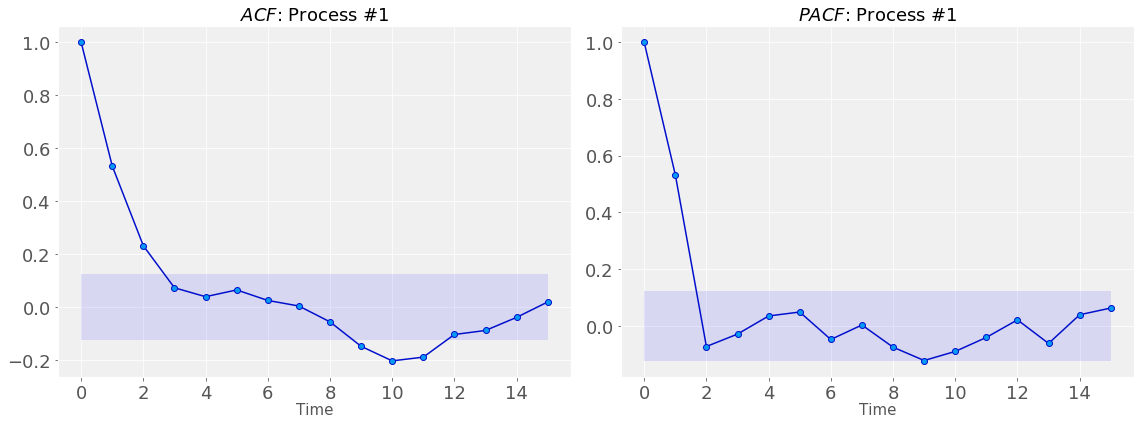

In [27]:
nlags=15
fig9, axes9 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_Exercise5_smallT.y_process1_smallT, 
            nlags, ax=axes9[0], title_string="Process #1", title_fontsize=18)
my_plot_pacf(df_Exercise5_smallT.y_process1_smallT, 
             nlags , ax=axes9[1], title_string="Process #1", title_fontsize=18)
fig9.tight_layout()

#### Solution to Exercise 5.1:
This is an ARMA($2$, $1$) process with $\phi_1=0.833$, $\phi_2=-0.167$, and $\theta_1=-0.339$.

#### Exercise 5.2: Guess this process

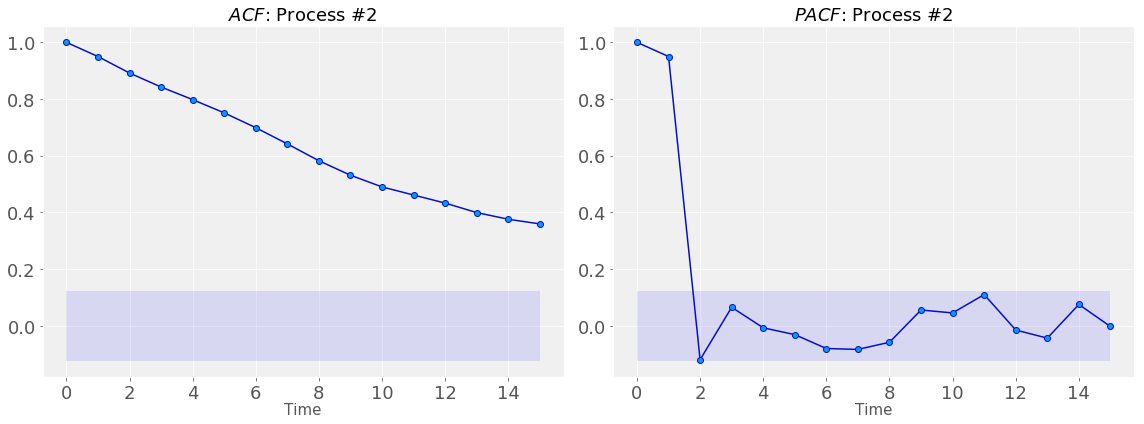

In [28]:
nlags=15
fig10, axes10 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_Exercise5_smallT.y_process3_smallT, 
            nlags, ax=axes10[0], title_string="Process #2", title_fontsize=18)
my_plot_pacf(df_Exercise5_smallT.y_process3_smallT, 
             nlags, ax=axes10[1], title_string="Process #2", title_fontsize=18)

fig10.tight_layout()

#### Solution to Exercise 5.2: 
This is an ARMA($1$,$1$) process with $\phi=0.9$ and $\theta=0.2$

#### Exercise 5.3: Guess this process

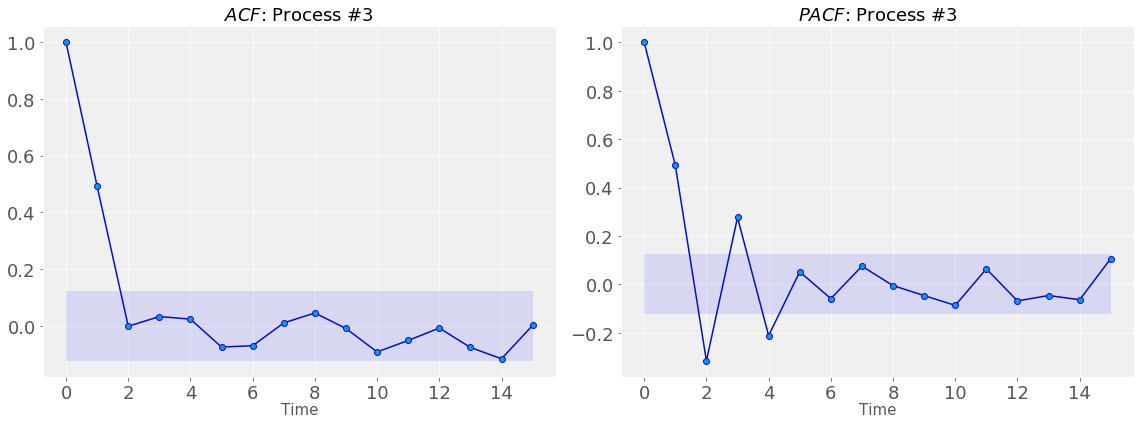

In [29]:
nlags=15
fig11, axes11 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_Exercise5_smallT.y_process4_smallT, nlags, 
            ax=axes11[0], title_string="Process #3", title_fontsize=18)
my_plot_pacf(df_Exercise5_smallT.y_process4_smallT, nlags, 
            ax=axes11[1], title_string="Process #3", title_fontsize=18)
fig11.tight_layout()

#### Solution to Exercise 5.3:
This is an MA($1$) process with $\theta=0.75$

#### Exercise 5.4: Guess this process

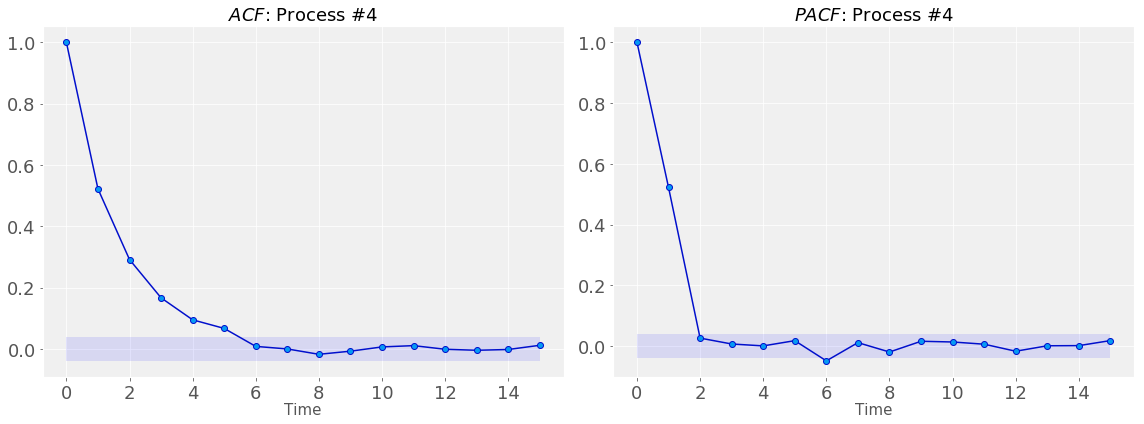

In [30]:
nlags=15
fig11, axes11 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_Exercise5_largeT.y_process4_largeT, nlags, 
            ax=axes11[0], title_string="Process #4", title_fontsize=18)
my_plot_pacf(df_Exercise5_largeT.y_process4_largeT, nlags, 
            ax=axes11[1], title_string="Process #4", title_fontsize=18)
fig11.tight_layout()

#### Solution to Exercise 5.4:
This is also an ARMA($2$, $1$) process with $\phi_1=0.833$, $\phi_2=-0.167$, and $\theta_1=-0.339$.

#### Exercise 5.5: Guess this process

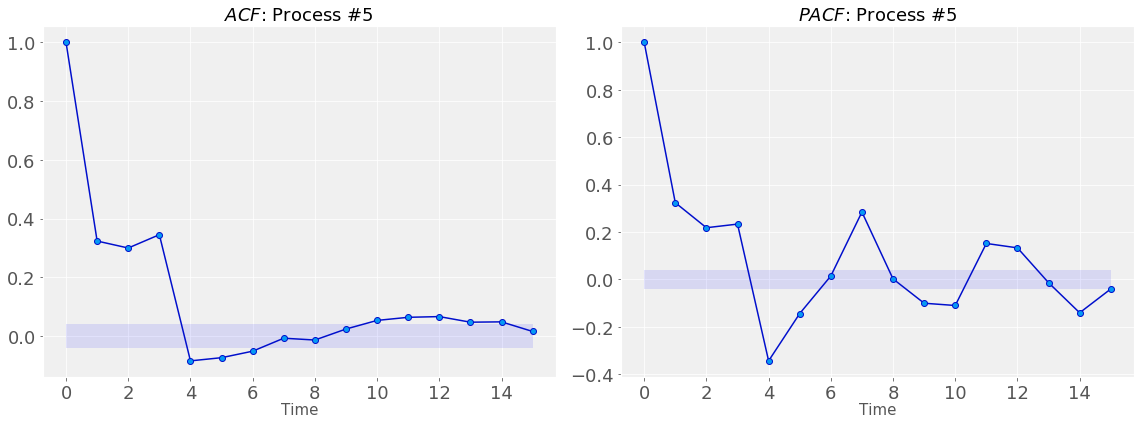

In [31]:
nlags=15
fig11, axes11 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_Exercise5_largeT.y_process3_largeT, nlags, 
            ax=axes11[0], title_string="Process #5", title_fontsize=18)
my_plot_pacf(df_Exercise5_largeT.y_process3_largeT, nlags, 
            ax=axes11[1], title_string="Process #5", title_fontsize=18)
fig11.tight_layout()

#### Solution to Exercise 5.5:
This is an MA($3$) process with $\theta_1=0.25$, $\theta_2=0.5$, and $\theta_3=0.75$.

Now to dealing with **non-stationarity**...

## Example 3: Differencing and determining the *integration order* of an ARIMA($p$,$n$,$q$) series

Recall that an ARMA($p$,$q$) process  can be written as

$$
x_t = \mu + \phi_1 x_{t-1} + \phi_2 x_{t-2} + ... \phi_p x_{t-p} + \epsilon_{t} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} +  ...  + \theta_q \epsilon_{t-q}
$$

Without loss of generality, we consider $\mu=0$. We can also rewrite our process in terms of polynomials with AR roots $\frac{1}{\lambda_1}, \frac{1}{\lambda_2}, ..., \frac{1}{\lambda_p}$ and MA roots $\frac{1}{\zeta_1}, \frac{1}{\zeta_2}, ..., \frac{1}{\zeta_q}$:

$$
(1 - \lambda_1 L)(1 - \lambda_2 L) ... (1 - \lambda_p L)x_t = \epsilon_{t} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} +  ...  + \theta_q \epsilon_{t-q}
$$

$$
(1 - \lambda_1 L)(1 - \lambda_2 L) ... (1 - \lambda_p L)x_t = (1 + \zeta_1 L)(1 + \zeta_2 L) ... (1 + \zeta_q L)\epsilon_{t}
$$

If $n$ of the roots, $\frac{1}{\lambda_i}$, are equal to 1, then we say that $x_t$ is a process that is **integrated of order** $n$: $I(n)$.  

**FACT 1:** An ARMA($p$,$q$) process is "sensible", i.e. *stationary*, if all roots of the *factored* AR lag polynomial lie <u>outside the unit circle</u>, $\mid \frac{1}{\lambda_i}\mid > 1$ for all $i=1,2,...,p$. There are no restrictions on the *factored* MA lag polynomial, but we do require the MA coefficients be square summable. 

**FACT 2:** An ARMA($p$,$q$) process with $n$ unit roots is called an ARIMA($p$,$n$,$q$), i.e. an ARMA($p$,$q$) process **integrated of order** $n$. 

**Problem:** Let's now determine the **order of integration** of one of the simulated data series in the file `arima_sims.csv`. 


Let's look at the *ACF* and *PACF* of the simulated data, as well as various differences of the process. We have to be diligent and avoid both <u>under-differencing</u>, as well as <u>over-differencing</u>. **Why?**

Let's load in the .csv files `'arima_smallT_sims.csv` and `'arima_largeT_sims.csv`. 

Once again, the first file contains simulated processes with <u>small</u> $T$ sample size, while the second file contains simulated processes with <u>large</u> $T$ sample size.

In [34]:
### Read in the data
df_arima_smallT = pd.read_csv('arima_smallT_sims.csv')
df_arima_largeT = pd.read_csv('arima_largeT_sims.csv')

print(df_arima_smallT.head(), '\n')
print(df_arima_largeT.head(), '\n')

print(df_arima_smallT.info(), '\n')
print(df_arima_largeT.info())

   y1_smallT  y2_smallT  y3_smallT  y4_smallT
0      0.471     -0.829      0.665      0.033
1     -0.515     -1.282      2.741     -0.577
2      0.441     -0.641      5.924      2.459
3      0.669     -0.455      8.534     -2.302
4     -0.107     -0.455     11.069     -1.544 

   y1_largeT  y2_largeT  y3_largeT  y4_largeT
0      0.216     -0.919     -0.159      1.864
1      0.125     -1.082     -0.482      0.959
2      0.496     -1.814     -1.718     -1.035
3     -3.865     -3.354     -2.642     -1.583
4      4.186     -7.005     -2.110     -1.674 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
y1_smallT    250 non-null float64
y2_smallT    250 non-null float64
y3_smallT    250 non-null float64
y4_smallT    250 non-null float64
dtypes: float64(4)
memory usage: 7.9 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
y1_largeT    2500 non-null float64
y2_largeT    250

**Question:** What is the **order of integration** for the process `y4_largeT` in the file `arima_largeT_sims.csv`?

**Note:** The correct amount of "differencing" is the <u>lowest order of differencing</u> such that a time series fluctuates around a well-defined mean value. <br>Also, the *ACF* plot decays fairly rapidly to zero, either from above or below.

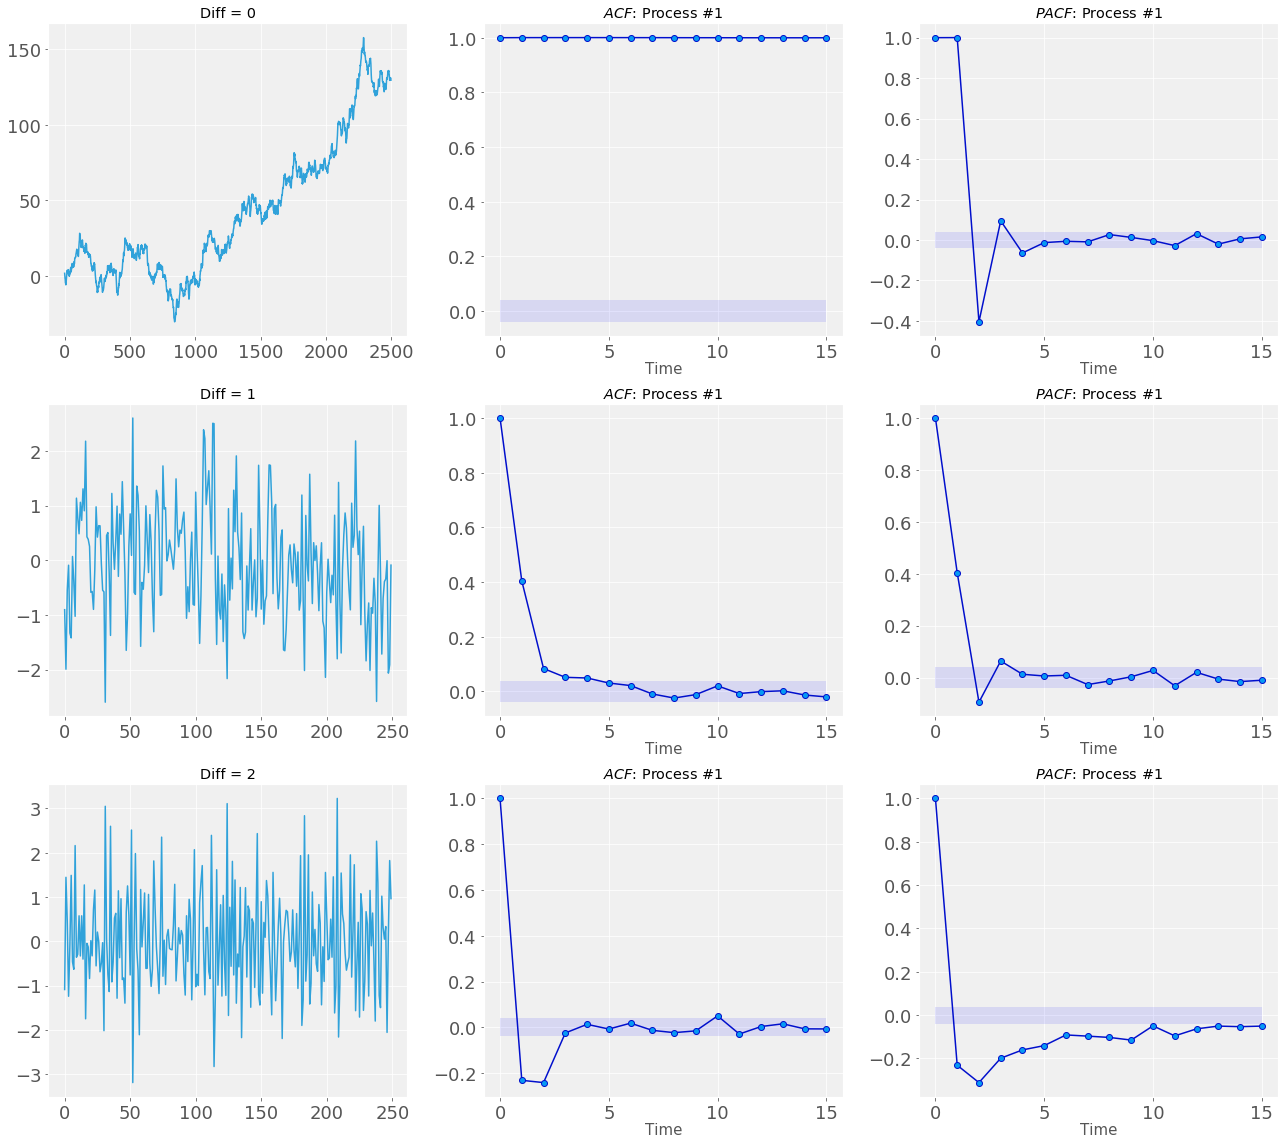

In [48]:
### 'y4_largeT'
ysim1 = df_arima_largeT.y4_largeT

### First plot the raw and differenced data, and then the ACF/PACF
fig12, axes12 = plt.subplots(nrows=3, ncols=3, figsize=(18,16))
for d in range(3):
    if d==0:
        Dysim = np.copy(ysim1)
        axes12[d,0].plot(Dysim) 
    else:
        Dysim = Dysim[1:] - Dysim[:-1]
        axes12[d,0].plot(Dysim[:250]) 
    axes12[d,0].set_title('Diff = %d'% d)
    
    ### ACF/PACF
    my_plot_acf(y=Dysim, nlags=15 , ax=axes12[d,1], title_string="Process #1")
    my_plot_pacf(y=Dysim, nlags=15 , ax=axes12[d,2], title_string="Process #1")

fig12.tight_layout()

**Solutions:** Order of integration for `y4_largeT` is 1, i.e., `y4_largeT` is $I(1)$. 

**Note:** This process is an ARIMA($1$,$1$, $2$) with:
* AR coefficients: $\phi_1=1.5$, $\phi_2=-0.5$
* MA coefficients: $\theta_1=-0.067$, $\theta_2=-0.133$ 


* AR roots: $\frac{1}{\lambda_1}=1$, $\frac{1}{\lambda_2}=2$
* MA roots: $\frac{1}{\zeta_1}=-3$, $\frac{1}{\zeta_2}=2.5$

#### Exercise 6.1: What is the "order of integration" for the process `y3_largeT` in the file `arima_largeT_sims.csv`? 
That is, how many times does the time series data need to be differenced for you to make it **stationary**?

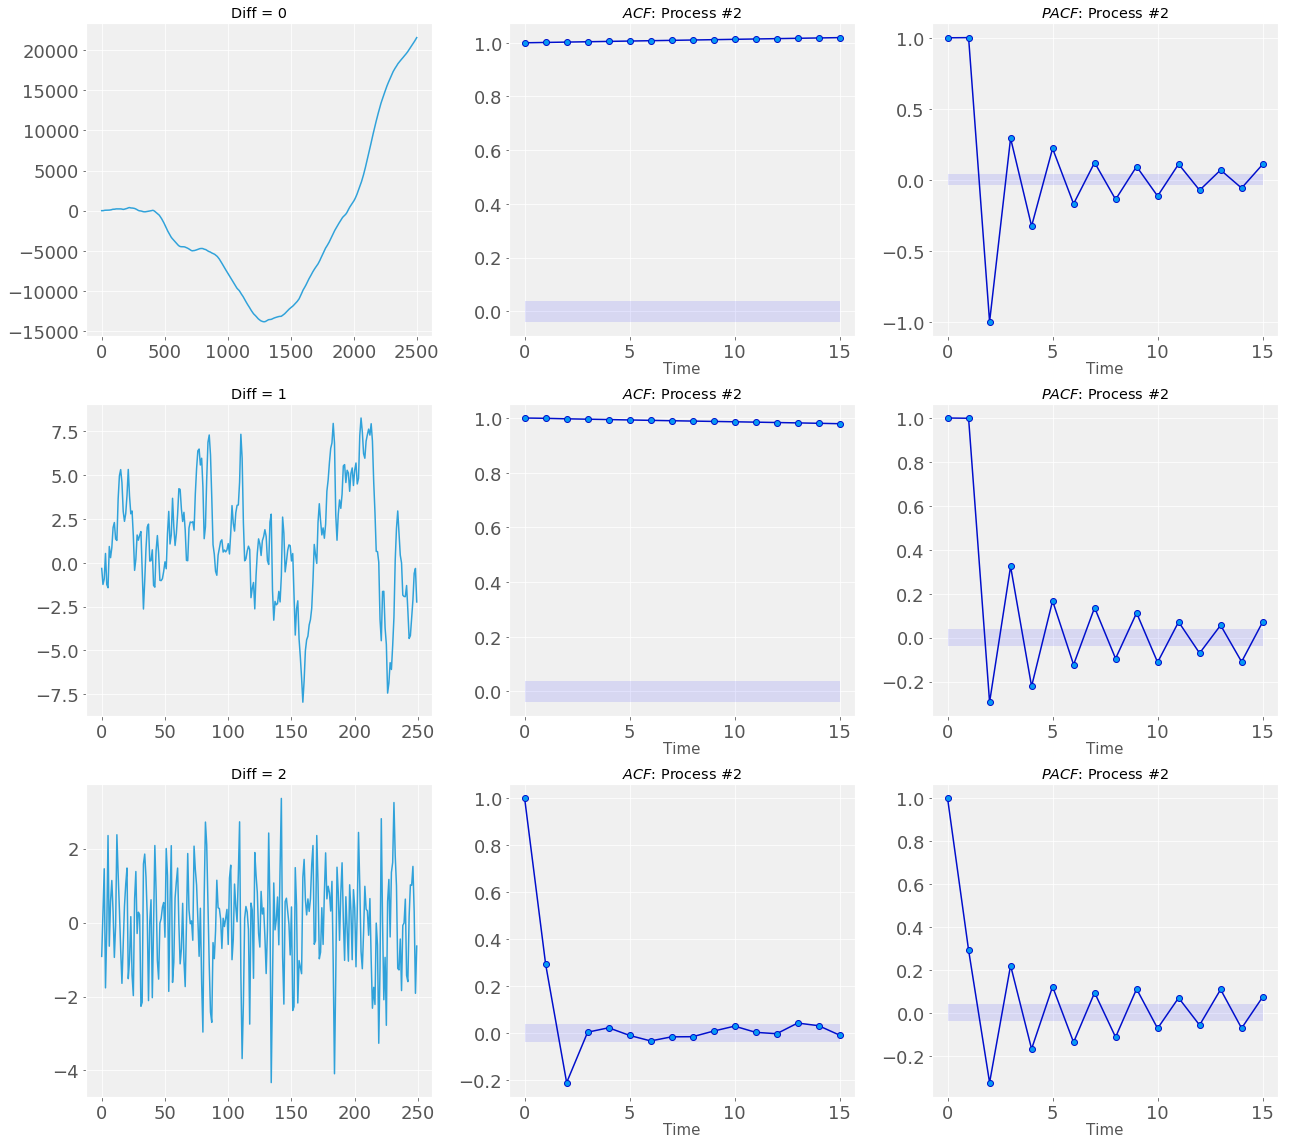

In [47]:
### 'y3_largeT'
ysim2 = df_arima_largeT.y3_largeT

### First plot the raw and differenced data, and then the ACF/PACF
fig13, axes13 = plt.subplots(nrows=3, ncols=3, figsize=(18,16))
for d in range(3):
    if d==0:
        Dysim = np.copy(ysim2)
        axes13[d,0].plot(Dysim)
    else:
        Dysim = Dysim[1:] - Dysim[:-1]
        axes13[d,0].plot(Dysim[:250]) 
    axes13[d,0].set_title('Diff = %d'% d)
    
    ### ACF/PACF
    my_plot_acf(y=Dysim, nlags=15, ax=axes13[d,1], title_string="Process #2")
    my_plot_pacf(y=Dysim, nlags=15, ax=axes13[d,2], title_string="Process #2")

fig13.tight_layout()

#### Solution to Exercise 6.1:
Order of integration for `y3_largeT` is 2, i.e., `y3_largeT` is $I(2)$. 

**Note:** This process is an ARIMA($0$,$2$,$2$) with:
* AR coefficients: $\phi_1=2$, $\phi_2=-1$
* MA coefficients: $\theta_1=0.667$, $\theta_2=-0.333$ 


* AR roots: $\frac{1}{\lambda_1}=1$, $\frac{1}{\lambda_2}=1$
* MA roots: $\frac{1}{\zeta_1}=-1$, $\frac{1}{\zeta_2}=3$

#### Exercise 6.2: What is the "order of integration" for the process `y3_smallT` in `arima_smallT_sims.csv`? 

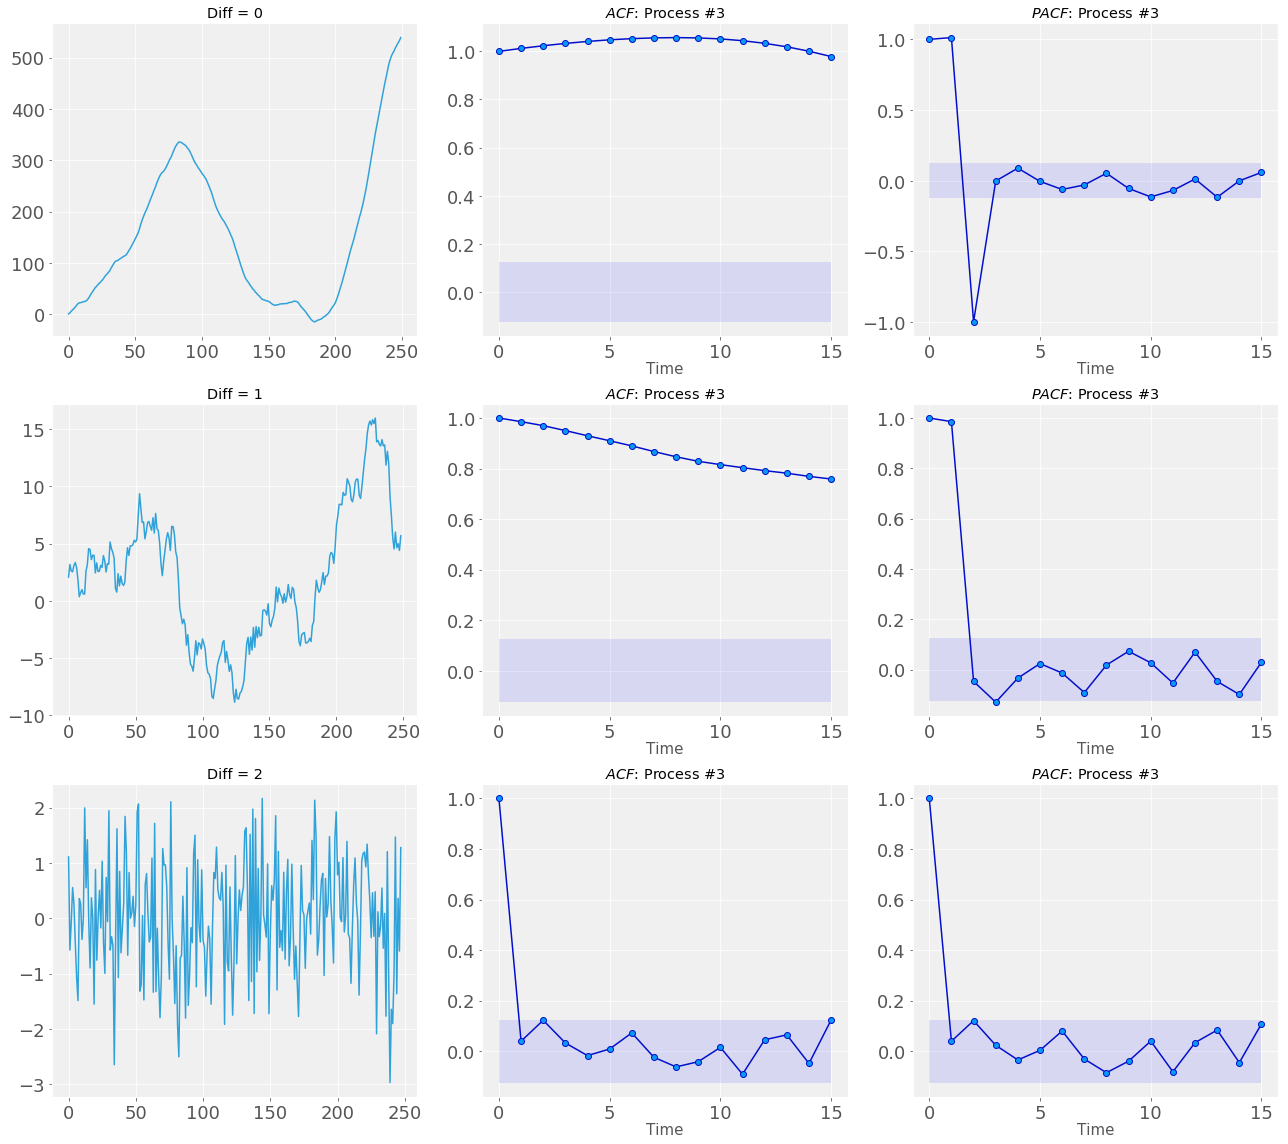

In [49]:
### 'y3_smallT'
ysim3 = df_arima_smallT.y3_smallT

### First plot the raw and differenced data, and then the ACF/PACF
fig14, axes14 = plt.subplots(nrows=3, ncols=3, figsize=(18,16))
for d in range(3):
    if d==0:
        Dysim = np.copy(ysim3)
        axes14[d,0].plot(Dysim)
    else:
        Dysim = Dysim[1:] - Dysim[:-1]
        axes14[d,0].plot(Dysim[:250])
    axes14[d,0].set_title('Diff = %d'% d)
    
    ### ACF/PACF
    my_plot_acf(y=Dysim, nlags=15, ax=axes14[d,1], title_string="Process #3")
    my_plot_pacf(y=Dysim, nlags=15, ax=axes14[d,2], title_string="Process #3")

fig14.tight_layout()

#### Solution to Exercise 6.2:
Order of integration for `y3_smallT` **appears to be 2**, i.e., `y3_smallT` is $I(2)$.

**Note:** BUT...this process is an ARIMA($1$,$1$,$0$) with:
* AR coefficients: $\phi_1=1.976$, $\phi_2=-0.976$


* AR roots: $\frac{1}{\lambda_1}=1$, $\frac{1}{\lambda_2}=1.025$


#### Exercise 6.3: What is the "order of integration" for the process `y2_largeT` in `arima_largeT_sims.csv`? 

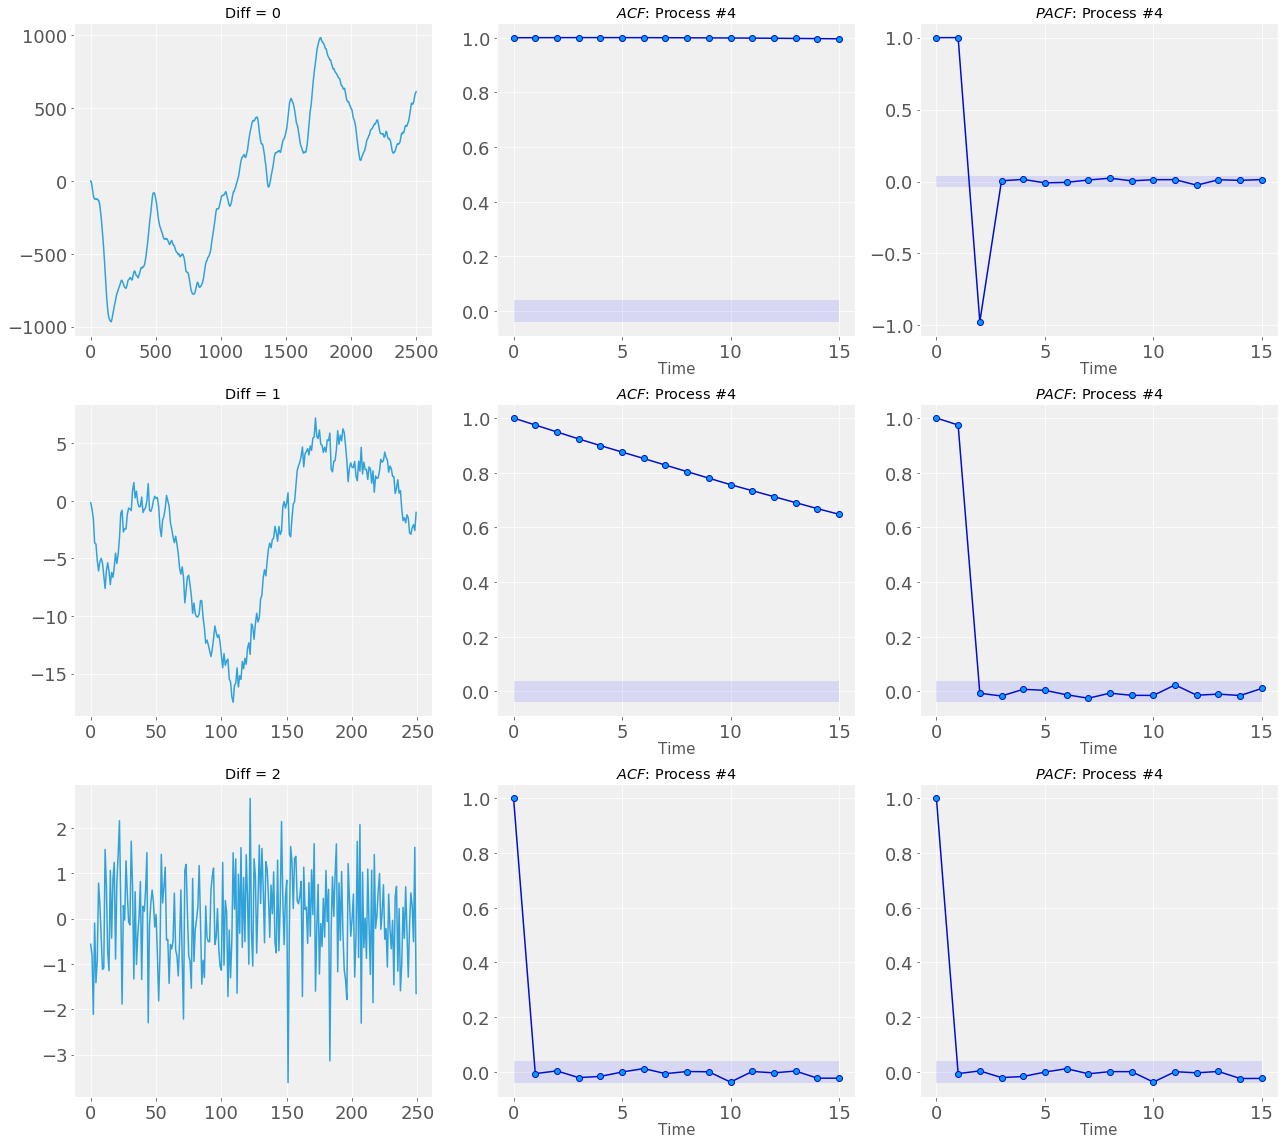

In [50]:
### 'y2_largeT'
ysim4 = df_arima_largeT.y2_largeT

### First plot the raw and differenced data, and then the ACF/PACF
fig15, axes15 = plt.subplots(nrows=3, ncols=3, figsize=(18,16))
for d in range(3):
    if d==0:
        Dysim = np.copy(ysim4)
        axes15[d,0].plot(Dysim)
    else:
        Dysim = Dysim[1:] - Dysim[:-1]
        axes15[d,0].plot(Dysim[:250])
    axes15[d,0].set_title('Diff = %d'% d)
    
    ### ACF/PACF
    my_plot_acf(y=Dysim, nlags=15, ax=axes15[d,1], title_string="Process #4")
    my_plot_pacf(y=Dysim, nlags=15, ax=axes15[d,2], title_string="Process #4")

fig15.tight_layout()

#### Solution to Exercise 6.3:

Order of integration for `y2_largeT` **appears to be 1**, i.e., `y2_largeT` is $I(1)$.

**Note:** AND...this process is the same one from **Exercise 6.2**; it is an ARIMA($1$,$1$,$0$) with:
* AR coefficients: $\phi_1=1.976$, $\phi_2=-0.976$


* AR roots: $\frac{1}{\lambda_1}=1$, $\frac{1}{\lambda_2}=1.025$


#### Exercise 6.4: What is the "order of integration" for the process `y1_largeT` in `arima_largeT_sims.csv`? 

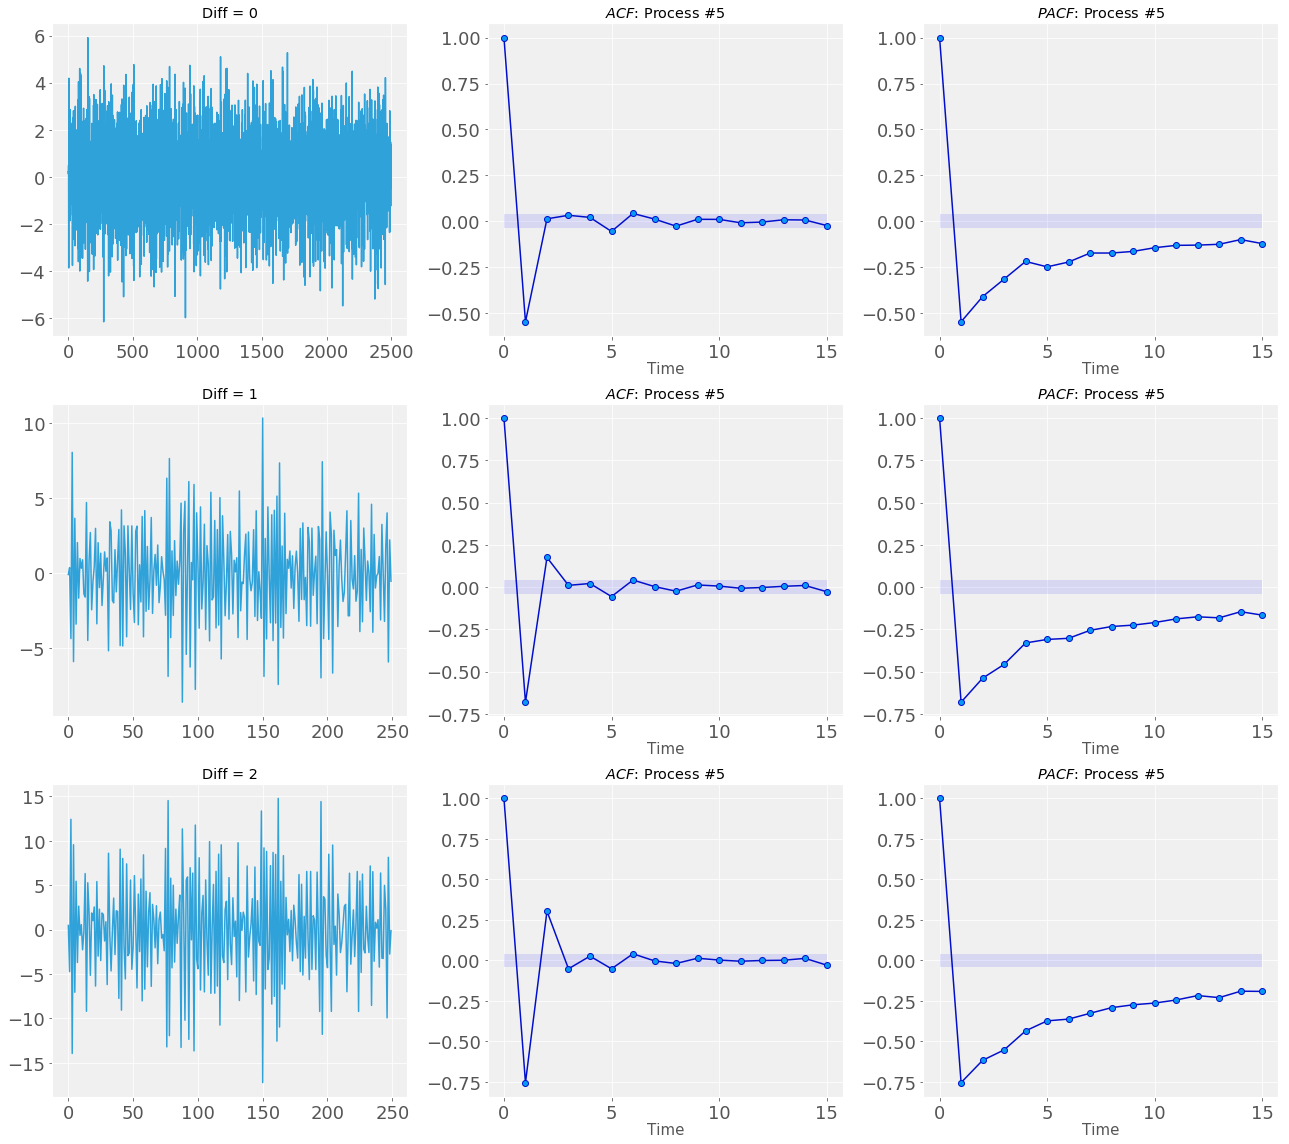

In [51]:
### 'y1_largeT'
ysim5 = df_arima_largeT.y1_largeT

### First plot the raw and differenced data, and then the ACF/PACF
fig16, axes16 = plt.subplots(nrows=3, ncols=3, figsize=(18,16))
for d in range(3):
    if d==0:
        Dysim = np.copy(ysim5)
        axes16[d,0].plot(Dysim)
    else:
        Dysim = Dysim[1:] - Dysim[:-1]
        axes16[d,0].plot(Dysim[:250])
    axes16[d,0].set_title('Diff = %d'% d)
    
    ### ACF/PACF
    my_plot_acf(y=Dysim, nlags=15, ax=axes16[d,1], title_string="Process #5")
    my_plot_pacf(y=Dysim, nlags=15, ax=axes16[d,2], title_string="Process #5")

fig16.tight_layout()

#### Solution to Exercise 6.4:

Order of integration for `y1_largeT` is 0, i.e., `y1_largeT` is $I(0)$.

**Note:** This process is an ARIMA($1$,$0$,$2$) with:
* AR coefficients: $\phi_1=0.5$
* MA coefficients: $\theta_1=-2$, $\theta_2=1$ 


* AR roots: $\frac{1}{\lambda_1}=2$
* MA roots: $\frac{1}{\zeta_1}=1$, $\frac{1}{\zeta_2}=1$

### Discussion of Exercises 6.2  and 6.3:

Notice how the sample size $T$ was crucial for getting a sufficiently close approximation to the **order of integration**. For small $T$, an AR(2) with a unit root appeared to be an $I(2)$ process, while for large $T$, the same AR(2) shows up as an $I(1)$ process. 

What is the issue? The issue is that the other root is very close to one, which in small samples, is hard to see. 

As the sample size **increases**, we are better able to tell what the **order of integration** is for a process.

### Discussion of Exercise 6.4:

This process was twice over-differenced since its $I(0)$.

## Example 4: Putting it all together.

Let's analyze **monthly dividends** (in USD ($) nominal billions) from the CRSP value-weighted portfolio return index.

In [79]:
df_crsp_div = pd.read_csv('crspvw_dividends_1927-2018.csv', parse_dates=['DATE'])
df_crsp_div.set_index(['DATE'], inplace=True, drop=True)
df_crsp_div = df_crsp_div[['crsp_div']].dropna()

print(df_crsp_div.head(),'\n')
print(df_crsp_div.tail(),'\n')

print(df_crsp_div.info())

            crsp_div
DATE                
1927-02-28     0.127
1927-03-31     0.182
1927-04-30     0.067
1927-05-31     0.132
1927-06-30     0.203 

            crsp_div
DATE                
2018-08-31    89.220
2018-09-28    61.013
2018-10-31    40.947
2018-11-30    89.125
2018-12-31    78.906 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1103 entries, 1927-02-28 to 2018-12-31
Data columns (total 1 columns):
crsp_div    1103 non-null float64
dtypes: float64(1)
memory usage: 17.2 KB
None


### Example 4.1
Let's plot the time series of the monthly dividend cash flows from 1927 to the present:

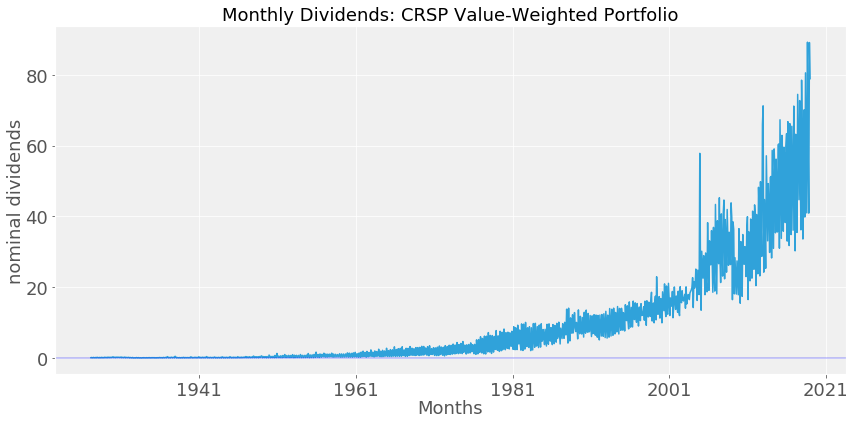

In [80]:
fig17, axes17 = plt.subplots(figsize=(12,6))
axes17.plot(df_crsp_div['crsp_div'])
axes17.set_xlabel('Months', fontsize=18)
axes17.set_ylabel('nominal dividends', fontsize=18)
axes17.set_title('Monthly Dividends: CRSP Value-Weighted Portfolio', fontsize=18)
axes17.axhline(y=0, linewidth=0.4)
fig17.tight_layout()

We can see **(1)** **EXPONENTIAL growth** and **(2)** **seasonalities**

### Example 4.2
Now, let's take natural logs:

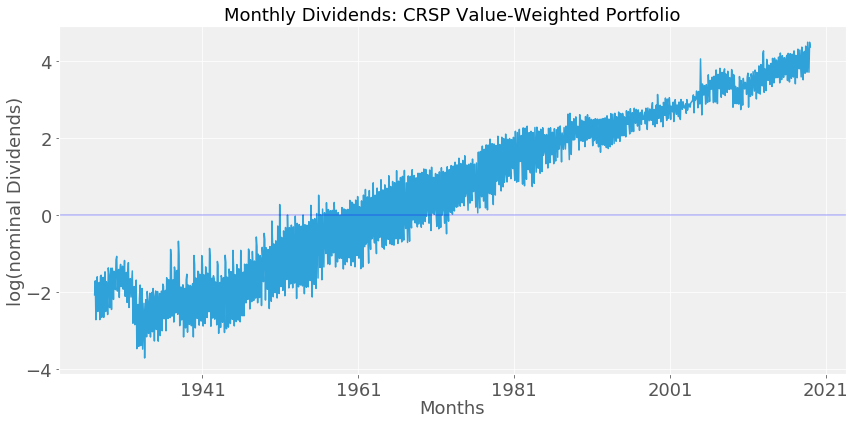

In [81]:
df_crsp_div['log_crsp_div'] = df_crsp_div['crsp_div'].apply(np.log)

fig18, axes18 = plt.subplots(figsize=(12,6))
axes18.plot(df_crsp_div['log_crsp_div'])
axes18.set_xlabel('Months', fontsize=18)
axes18.set_ylabel('log(nominal Dividends)', fontsize=18)
axes18.set_title('Monthly Dividends: CRSP Value-Weighted Portfolio', fontsize=18)
axes18.axhline(y=0, linewidth=0.4)
fig18.tight_layout()

We now see **(1)** **LINEAR growth** and **(2)** **seasonalities**

### Example 4.3

Let's compute the *ACF* and *PACF* for the log of CRSP dividends, $log(dividends_{1m, crsp})$, and the first difference of the log of CRSP dividends, $\Delta log(dividends_{1m, crsp})$:

            crsp_div  log_crsp_div  Dlog_crsp_div
DATE                                             
1927-03-31     0.182        -1.701          0.362
1927-04-30     0.067        -2.710         -1.009
1927-05-31     0.132        -2.025          0.685
1927-06-30     0.203        -1.596          0.429
1927-07-30     0.082        -2.496         -0.899
            crsp_div  log_crsp_div  Dlog_crsp_div
DATE                                             
2018-08-31    89.220         4.491          0.777
2018-09-28    61.013         4.111         -0.380
2018-10-31    40.947         3.712         -0.399
2018-11-30    89.125         4.490          0.778
2018-12-31    78.906         4.368         -0.122


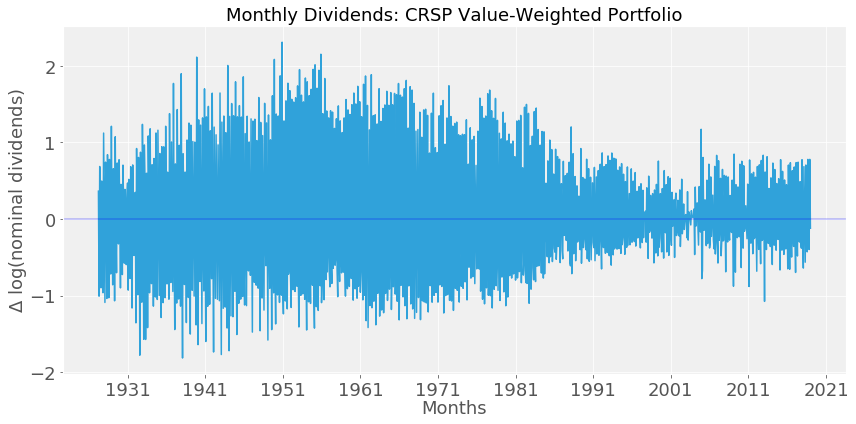

In [82]:
df_crsp_div['Dlog_crsp_div'] = df_crsp_div['log_crsp_div'] -\
                               df_crsp_div['log_crsp_div'].shift(1)
df_crsp_div = df_crsp_div.dropna() # drop missings

print(df_crsp_div.head())
print(df_crsp_div.tail())

fig19, axes19 = plt.subplots(figsize=(12,6))
axes19.plot(df_crsp_div['Dlog_crsp_div'])
axes19.set_xlabel('Months', fontsize=18)
axes19.set_ylabel('$\Delta$ log(nominal dividends)', fontsize=18)
axes19.set_title('Monthly Dividends: CRSP Value-Weighted Portfolio', fontsize=18)
axes19.axhline(y=0, linewidth=0.4)
fig19.tight_layout()

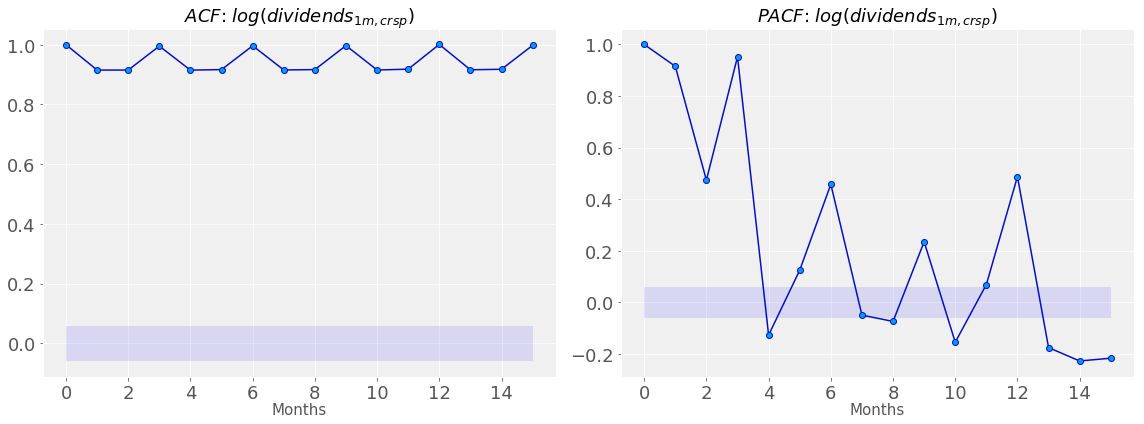

In [95]:
### ACF/PCF for df_crsp_div['log_crsp_div_bill']
nlags=15
fig20, axes20 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_crsp_div['log_crsp_div'], nlags, 
            ax=axes20[0], title_string="$log(dividends_{1m,crsp})$", 
            title_fontsize=18, xlabel_string="Months")
my_plot_pacf(df_crsp_div['log_crsp_div'], nlags, 
            ax=axes20[1], title_string="$log(dividends_{1m,crsp})$", 
             title_fontsize=18, xlabel_string="Months")
fig20.tight_layout()

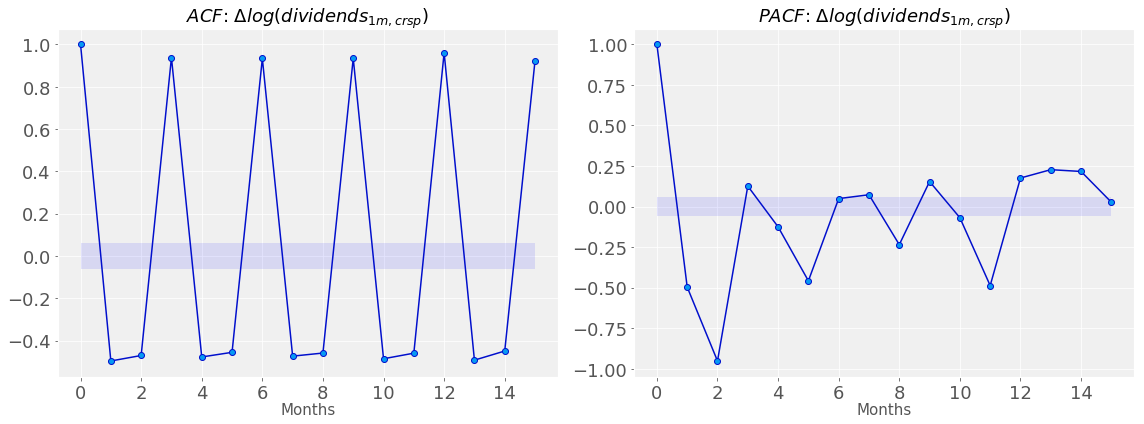

In [96]:
### ACF/PCF for df_crsp_div['Dlog_crsp_div_billions']
nlags=15
fig21, axes21 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_crsp_div['Dlog_crsp_div'], nlags, 
            ax=axes21[0], title_string="$\Delta log(dividends_{1m,crsp})$", 
            title_fontsize=18, xlabel_string="Months")
my_plot_pacf(df_crsp_div['Dlog_crsp_div'], nlags, 
            ax=axes21[1], title_string="$\Delta log(dividends_{1m,crsp})$", 
             title_fontsize=18, xlabel_string="Months")

fig21.tight_layout()

We can still see the seasonality!
Let's remove it.

### Example 4.4

Let's remove the seasonality in dividends by aggregating them over the last 12 months. 

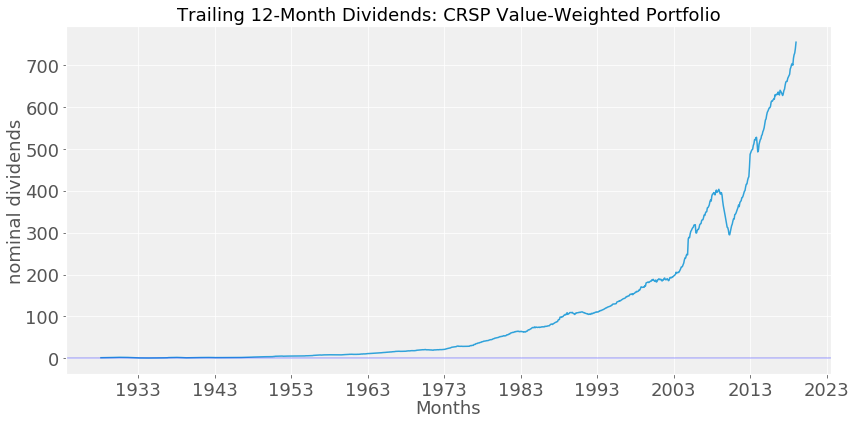

In [85]:
df_crsp_div['crsp_div_12m'] = df_crsp_div['crsp_div'].rolling(12).sum()
df_crsp_div = df_crsp_div.dropna() # drop missings
#print(df_crsp_div.head())
#print(df_crsp_div.tail())

fig22, axes22 = plt.subplots(figsize=(12,6))
axes22.plot(df_crsp_div['crsp_div_12m'])
axes22.set_xlabel('Months', fontsize=18)
axes22.set_ylabel('nominal dividends', fontsize=18)
axes22.set_title('Trailing 12-Month Dividends: CRSP Value-Weighted Portfolio', fontsize=18)
axes22.axhline(y=0, linewidth=0.4)
fig22.tight_layout()

Now, we only see **EXPONENTIAL growth**. Let's take logs and first differences of the logs:

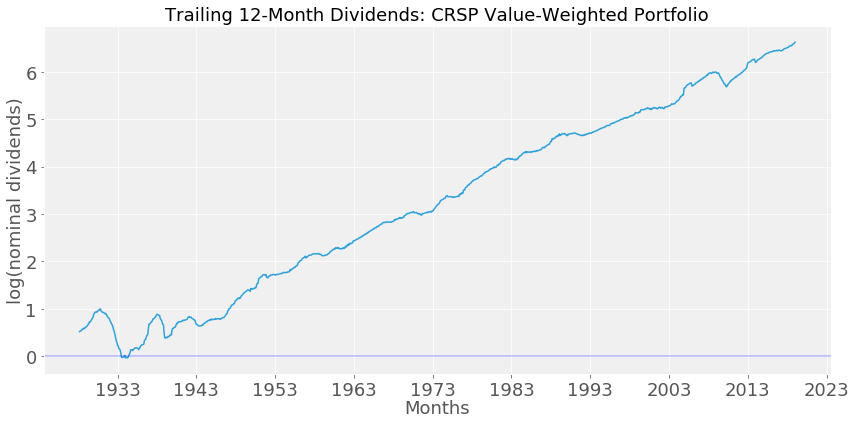

In [86]:
df_crsp_div['log_crsp_div_12m'] = df_crsp_div['crsp_div_12m'].apply(np.log)
df_crsp_div = df_crsp_div.dropna() # drop missings
#print(df_crsp_div.head())
#print(df_crsp_div.tail())

fig23, axes23 = plt.subplots(figsize=(12,6))
axes23.plot(df_crsp_div['log_crsp_div_12m'])
axes23.set_xlabel('Months', fontsize=18)
axes23.set_ylabel('log(nominal dividends)', fontsize=18)
axes23.set_title('Trailing 12-Month Dividends: CRSP Value-Weighted Portfolio', fontsize=18)
axes23.axhline(y=0, linewidth=0.4)
fig23.tight_layout()

We get **LINEAR growth**. The seasonality is gone.

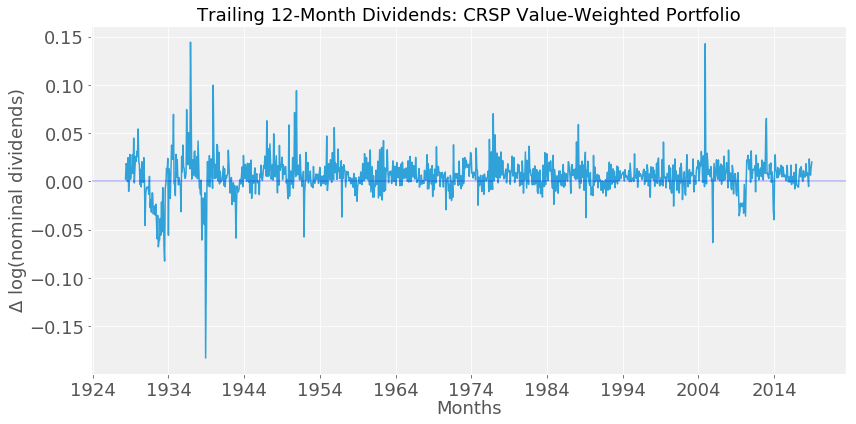

In [88]:
df_crsp_div['Dlog_crsp_div_12m'] = df_crsp_div['log_crsp_div_12m'] - \
                                   df_crsp_div['log_crsp_div_12m'].shift(1)
df_crsp_div = df_crsp_div.dropna() # drop missings
#print(df_crsp_div.head())
#print(df_crsp_div.tail())

fig24, axes24 = plt.subplots(figsize=(12,6))
axes24.plot(df_crsp_div['Dlog_crsp_div_12m'])
axes24.set_xlabel('Months', fontsize=18)
axes24.set_ylabel('$\Delta$ log(nominal dividends)', fontsize=18)
axes24.set_title('Trailing 12-Month Dividends: CRSP Value-Weighted Portfolio', fontsize=18)
axes24.axhline(y=0, linewidth=0.4)
fig24.tight_layout()

With natural log differences in our trailing 12-month dividend, it appears we have a stationary process, with no "trend" or "seasonality."

### Example 4.5

Once again, let's compute the *ACF* and *PACF* for the log of our 12-month CRSP dividends, $log(dividends_{12m, crsp})$, and the first difference of the log of CRSP dividends, $\Delta log(dividends_{12m, crsp})$:

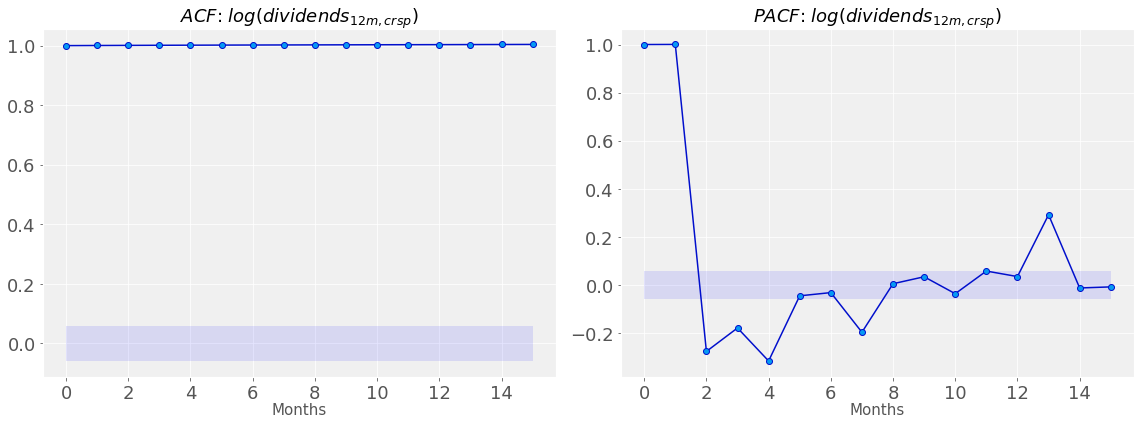

In [97]:
### ACF/PCF for df_crsp_div['log_crsp_div_bill_12m']
nlags=15
fig25, axes25 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_crsp_div['log_crsp_div_12m'], nlags, 
            ax=axes25[0], title_string="$log(dividends_{12m, crsp})$", 
            title_fontsize=18, xlabel_string="Months")
my_plot_pacf(df_crsp_div['log_crsp_div_12m'], nlags, 
            ax=axes25[1], title_string="$log(dividends_{12m, crsp})$", 
             title_fontsize=18, xlabel_string="Months")
fig25.tight_layout()

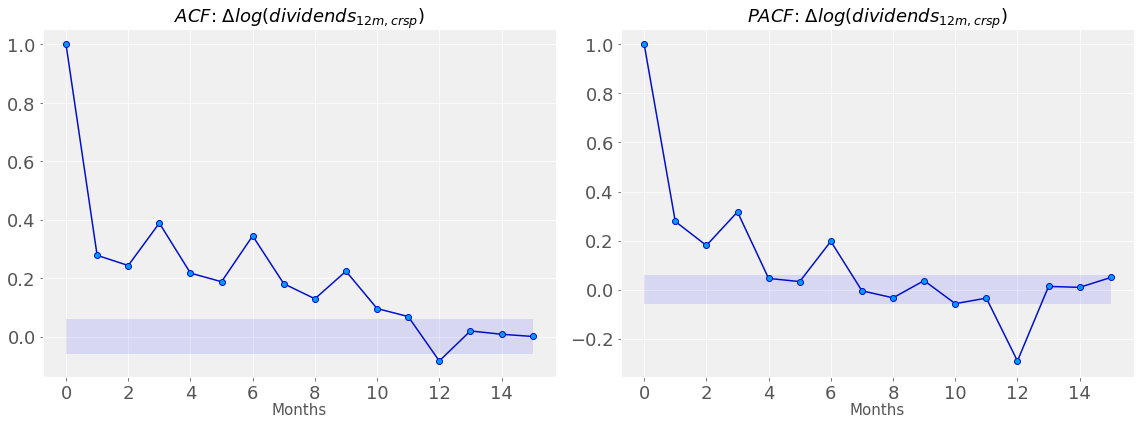

In [98]:
### ACF/PCF for df_crsp_div['Dlog_crsp_div_bill']
nlags=15
fig26, axes26 = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
my_plot_acf(df_crsp_div['Dlog_crsp_div_12m'], nlags, 
            ax=axes26[0], title_string="$\Delta log(dividends_{12m, crsp})$", 
            title_fontsize=18, xlabel_string="Months")
my_plot_pacf(df_crsp_div['Dlog_crsp_div_12m'], nlags, 
            ax=axes26[1], title_string="$\Delta  log(dividends_{12m, crsp})$", 
             title_fontsize=18, xlabel_string="Months")
fig26.tight_layout()

**Question:** What ARMA($p$,$q$) processes do both $log(dividends_{12m, crsp})$ and $\Delta log(dividends_{12m, crsp})$ follow?

### Exercise 7 (Optional): Parsimonious MA($1$) model

**Question** Simulate the following MA($1$) model:
$$
y_t = \varepsilon_t - \varepsilon_{t-1} 
$$

What is a particuarly parsimonious way in which we can transform this model?

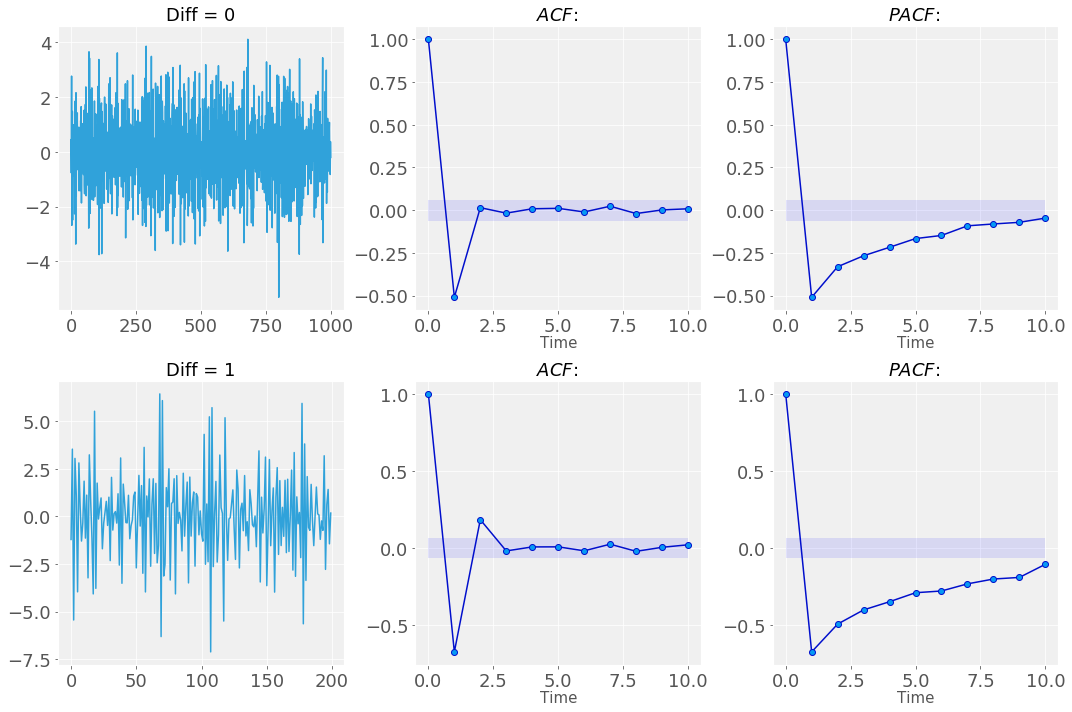

In [92]:
### Simulate
np.random.seed(5)
ysim = simulate_arma(ma=[-1], nsample=1000).squeeze()

### Note that differencing doesn't help
fig27, axes27 = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for d in range(2):
    if d==0:
        Dysim = np.copy(ysim)
        axes27[d,0].plot(Dysim)
    else:
        Dysim = Dysim[1:] - Dysim[:-1]
        axes27[d,0].plot(Dysim[:200])
    axes27[d,0].set_title('Diff = %d'% d, fontsize=18)
    ### ACF/PACF
    my_plot_acf(y=Dysim, nlags=10 , ax=axes27[d,1], title_fontsize=18)
    my_plot_pacf(y=Dysim, nlags=10 , ax=axes27[d,2], title_fontsize=18)
    
fig27.tight_layout()

By cumulating the $y_t$ process over time, we can get a much more parsimonious representation! 

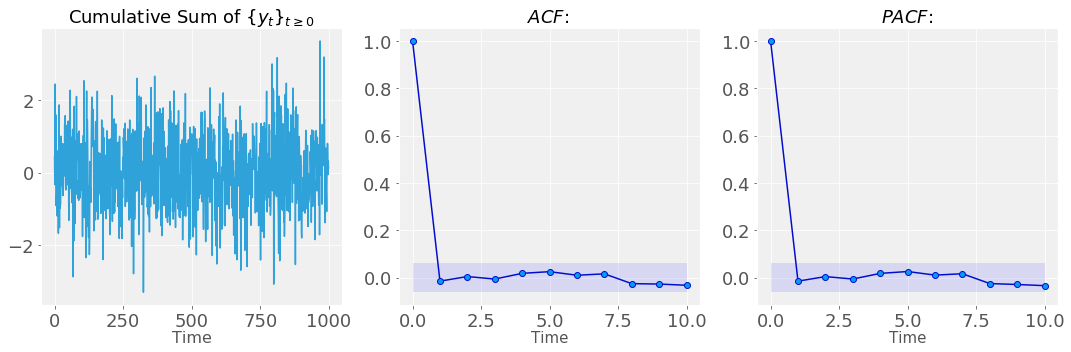

In [93]:
### Let's instead consider the cumulative sum: {sum from 0 to t}y_t = e_t
y_cumsum = np.cumsum(ysim) #https://docs.scipy.org/doc/numpy/reference/generated/numpy.cumsum.html

fig28, axes28 = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes28[0].plot(y_cumsum)
axes28[0].set_xlabel('Time', fontsize=16)
axes28[0].set_title("Cumulative Sum of $\{y_t\}_{t\geq0}$", fontsize=18)

### ACF/PACF
my_plot_acf(y=y_cumsum, nlags=10 , ax=axes28[1], title_fontsize=18)
my_plot_pacf(y=y_cumsum, nlags=10 , ax=axes28[2], title_fontsize=18)

fig28.tight_layout()

That is all for today! 😎